# HiPPO Matrices
---

## Table of Contents
* [Loading In Necessary Packages](#load-packages)
* [Instantiate The HiPPO Matrix](#instantiate-the-hippo-matrix)
    * [Translated Legendre (LegT)](#translated-legendre-legt)
        * [LegT](#legt)
        * [LMU](#lmu)
    * [Translated Laguerre (LagT)](#translated-laguerre-lagt)
    * [Scaled Legendre (LegS)](#scaled-legendre-legs)
    * [Fourier Basis](#fourier-basis)
        * [Fourier Recurrent Unit (FRU)](#fourier-recurrent-unit-fru)
        * [Truncated Fourier (FouT)](#truncated-fourier-fout)
        * [Fourier With Decay (FourD)](#fourier-with-decay-fourd)
* [Gu's Linear Time Invariant (LTI) HiPPO Operator](#gus-hippo-legt-operator)
* [Gu's Scale invariant (LSI) HiPPO Operator](#gus-scale-invariant-hippo-legs-operator)
* [Implementation Of General HiPPO Operator](#implementation-of-general-hippo-operator)
* [Test Generalized Bilinear Transform and Zero Order Hold Matrices](#test-generalized-bilinear-transform-and-zero-order-hold-matrices)
    * [Testing Forward Euler on GBT matrices](#testing-forward-euler-transform-for-lti-and-lsi)
    * [Testing Backward Euler on GBT matrices](#testing-backward-euler-transform-for-lti-and-lsi-on-legs-matrices)
    * [Testing Bidirectional on GBT matrices](#testing-lti-and-lsi-operators-with-bidirectional-transform)
    * [Testing ZOH on GBT matrices](#testing-zoh-transform-for-lti-and-lsi-on-legs-matrices)
* [Testing HiPPO Operators](#test-hippo-operators)
    * [Testing Forward Euler on HiPPO Operators](#testing-lti-and-lsi-operators-with-forward-euler-transform)
    * [Testing Backward Euler on HiPPO Operators](#testing-lti-and-lsi-operators-with-backward-euler-transform)
    * [Testing Bidirectional on HiPPO Operators](#testing-lti-and-lsi-operators-with-bidirectional-transform)
    * [Testing ZOH on HiPPO Operators](#testing-lti-and-lsi-operators-with-zoh-transform)
---


## Load Packages

In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join("../../../"))
print(f"module_path: {module_path}")
if module_path not in sys.path:
    print(f"Adding {module_path} to sys.path")
    sys.path.append(module_path)

module_path: /home/beegass/Documents/Coding/s4mer


In [2]:
os.environ["TF_FORCE_UNIFIED_MEMORY"] = "1"

In [3]:
## import packages
from typing import Union

import jax
import jax.numpy as jnp
import einops
import matplotlib.pyplot as plt
import numpy as np
import torch

from src.models.hippo.hr_hippo import HRHiPPO_LSI, HRHiPPO_LTI

# import modules
from src.models.hippo.hippo import HiPPOLSI, HiPPOLTI

from src.data.process import whitesignal

In [4]:
print(jax.devices())
print(f"The Device: {jax.lib.xla_bridge.get_backend().platform}")

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]
The Device: gpu


In [5]:
print(f"MPS enabled: {torch.backends.mps.is_available()}")

MPS enabled: False


In [6]:
torch.set_printoptions(linewidth=150)
np.set_printoptions(linewidth=150)
jnp.set_printoptions(linewidth=150)

In [7]:
seed = 1701
key = jax.random.PRNGKey(seed)

In [8]:
np.random.seed(0)

In [9]:
num_copies = 10
subkeys = jax.random.split(key, num=num_copies)
key = subkeys[0]

### Plotting function that instantiates signal and builds reconstructions for respective HiPPOs

In [10]:
def plot(T, dt, N, signal, vals, alpha: float = 0.5):

    u = signal
    _u = einops.rearrange(u, "1 seq_len -> seq_len")  # squeeze

    plt.figure(figsize=(16, 8))
    offset = 0.0
    plt.plot(vals, _u + offset, "k", linewidth=1.0)

    recon_dict = {}

    # Linear Time Invariant (LTI) methods x' = Ax + Bu
    lti_methods = [
        "legs",
        "legt",
        "lmu",
        "lagt",
        "fout",
    ]

    u = einops.rearrange(u, "batch seq_len-> batch seq_len 1")  # transposing

    for method in lti_methods:
        lambda_n = None
        if method == "legt":
            lambda_n = 1.0
        elif method == "lmu":
            lambda_n = 2.0

        hippo_lti = HiPPOLTI(
            N=N,
            step_size=dt,
            lambda_n=lambda_n,
            alpha=0.0,
            beta=1.0,
            GBT_alpha=alpha,
            measure=method,
            basis_size=T,
            dtype=jnp.float32,
            unroll=False,
        )
        u = jnp.asarray(u, dtype=jnp.float32)  # convert torch array to jax array
        params_lti = hippo_lti.init(subkeys[7], f=u)
        hippo_lti = hippo_lti.bind(params_lti)

        c = hippo_lti.__call__(f=u)
        y = hippo_lti.reconstruct(c)

        spec_y = y[0]  # get 0th batch
        spec_y = einops.rearrange(spec_y, "seq_len 1 -> seq_len")  # (64, 1) -> (64)
        spec_y = jnp.flip(spec_y, axis=0)

        recon_dict[method + "lti"] = spec_y

        plt.plot(vals[-len(spec_y) :], spec_y, label=method)

    lsi_methods = ["legs"]
    for method in lsi_methods:
        hippo_lsi = HiPPOLSI(
            N=N,
            max_length=int(T / dt),
            step_size=dt,
            lambda_n=1.0,
            alpha=0.0,
            beta=1.0,
            GBT_alpha=alpha,
            measure=method,
            dtype=jnp.float32,
            unroll=True,
        )
        u = jnp.asarray(u, dtype=jnp.float32)  # convert torch array to jax array
        params_lsi = hippo_lsi.init(subkeys[8], f=u)
        hippo_lsi = hippo_lsi.bind(params_lsi)

        c = hippo_lsi.__call__(f=u)
        y = hippo_lsi.reconstruct(c)
        y = einops.rearrange(
            y, "batch seq_len seq_len2 input_len -> batch seq_len input_len seq_len2"
        )

        spec_y = y[0][-1]  # get 0th batch
        spec_y = einops.rearrange(spec_y, "1 seq_len -> seq_len")  # (64, 1) -> (64)

        recon_dict[method + "lsi"] = spec_y

        plt.plot(vals[-len(spec_y) :], spec_y, label=method + " (scaled)")

    # plt.xlabel('Time (normalized)', labelpad=-10)
    plt.legend()
    plt.savefig(f"function_approximation.pdf", bbox_inches="tight")
    plt.show()
    plt.close()

    return _u, recon_dict

### Plotting function that instantiates signal and builds reconstructions for respective HiPPOs using Hazy Research's code

In [11]:
def gu_plot(T, dt, N, signal, vals, alpha: Union[float, str] = 0.5):

    u = signal
    _u = einops.rearrange(u, "1 seq_len -> seq_len")  # squeeze

    u = torch.tensor(u, dtype=torch.float)

    plt.figure(figsize=(16, 8))
    offset = 0.0
    plt.plot(vals, _u + offset, "k", linewidth=1.0)

    recon_dict = {}

    # Linear Time Invariant (LTI) methods x' = Ax + Bu
    lti_methods = [
        "legs",
        "legt",
        "lmu",
        "lagt",
        "fout",
    ]

    u = einops.rearrange(u, "batch seq_len -> seq_len batch 1")

    for method in lti_methods:
        lambda_n = None
        if method == "legt":
            lambda_n = 1.0
        elif method == "lmu":
            lambda_n = 2.0

        gu_hippo_lti = HRHiPPO_LTI(
            N=N,
            method=method,
            dt=dt,
            T=T,
            discretization=alpha,
            lambda_n=lambda_n,
            alpha=0.0,
            beta=1.0,
            c=0.0,
        )  # The Gu's

        _, c_k = gu_hippo_lti(u, fast=False)
        y = gu_hippo_lti.reconstruct(c_k)

        spec_y = y[0]  # get 0th batch
        spec_y = einops.rearrange(spec_y, "seq_len 1 -> seq_len")  # (64, 1) -> (64)
        spec_y = spec_y.flip(dims=(0,))

        recon_dict[method + "lti"] = spec_y

        plt.plot(vals[-len(spec_y) :], spec_y, label=method)

    lsi_methods = ["legs"]

    for method in lsi_methods:
        gu_hippo_lsi = HRHiPPO_LSI(
            N=N,
            method=method,
            max_length=int(T / dt),
            discretization=alpha,
            lambda_n=1.0,
            alpha=0.0,
            beta=1.0,
        )  # The Gu's

        c_s, _ = gu_hippo_lsi(u, fast=False)
        y = gu_hippo_lsi.reconstruct(c_s)
        y = einops.rearrange(
            y, "batch seq_len seq_len2 input_len -> batch seq_len input_len seq_len2"
        )

        spec_y = y[0][-1]  # get 0th batch
        spec_y = einops.rearrange(spec_y, "1 seq_len -> seq_len")  # (64, 1) -> (64)

        recon_dict[method + "lsi"] = spec_y

        plt.plot(vals[-len(spec_y) :], spec_y, label=method + " (scaled)")

    # plt.xlabel('Time (normalized)', labelpad=-10)
    plt.legend()
    plt.savefig(f"gu_function_approximation.pdf", bbox_inches="tight")
    plt.show()
    plt.close()

    return _u, recon_dict

## Navigation To Table Of Contents
---
* [Table Of Contents](#table-of-contents)
* [Loading In Necessary Packages](#load-packages)
* [Instantiate The HiPPO Matrix](#instantiate-the-hippo-matrix)
* [Gu's Linear Time Invariant (LTI) HiPPO Operator](#gus-hippo-legt-operator)
* [Gu's Scale invariant (LSI) HiPPO Operator](#gus-scale-invariant-hippo-legs-operator)
* [Implementation Of General HiPPO Operator](#implementation-of-general-hippo-operator)
* [Test Generalized Bilinear Transform and Zero Order Hold Matrices](#test-generalized-bilinear-transform-and-zero-order-hold-matrices)
* [Testing HiPPO Operators](#test-hippo-operators)
---

### Plot that shows comparison between our implementation, Hazy Research's next to that of the original signal

In [12]:
def plot_comparison(u, gu_y, y, method="LegS"):
    plt.figure(figsize=(18, 8))
    plt.plot(u, label="Original Signal", linewidth=5.5, color="k")
    plt.plot(
        gu_y,
        linestyle="--",
        label="Gu's reconstruction - " + method,
        dashes=(5, 1),
        linewidth=2.5,
        color="b",
    )
    plt.plot(
        y,
        linestyle=":",
        label="reconstruction - " + method,
        dashes=(5, 10),
        linewidth=2.5,
        color="r",
    )
    plt.legend()

In [13]:
N = 64
T = 3
dt = 1e-3
freq = 3.0

vals = np.arange(0.0, T, dt)
signal = whitesignal(subkeys[4], T, dt, freq=freq, batch_shape=(1,))

### Testing (LTI and LSI) Reconstructions With Forward Euler Transform

/home/beegass/.cache/pypoetry/virtualenvs/s4mer-pkg-jZnBSgjq-py3.8/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:5117: RuntimeWarning: overflow encountered in cast
  return binary_op(*args)


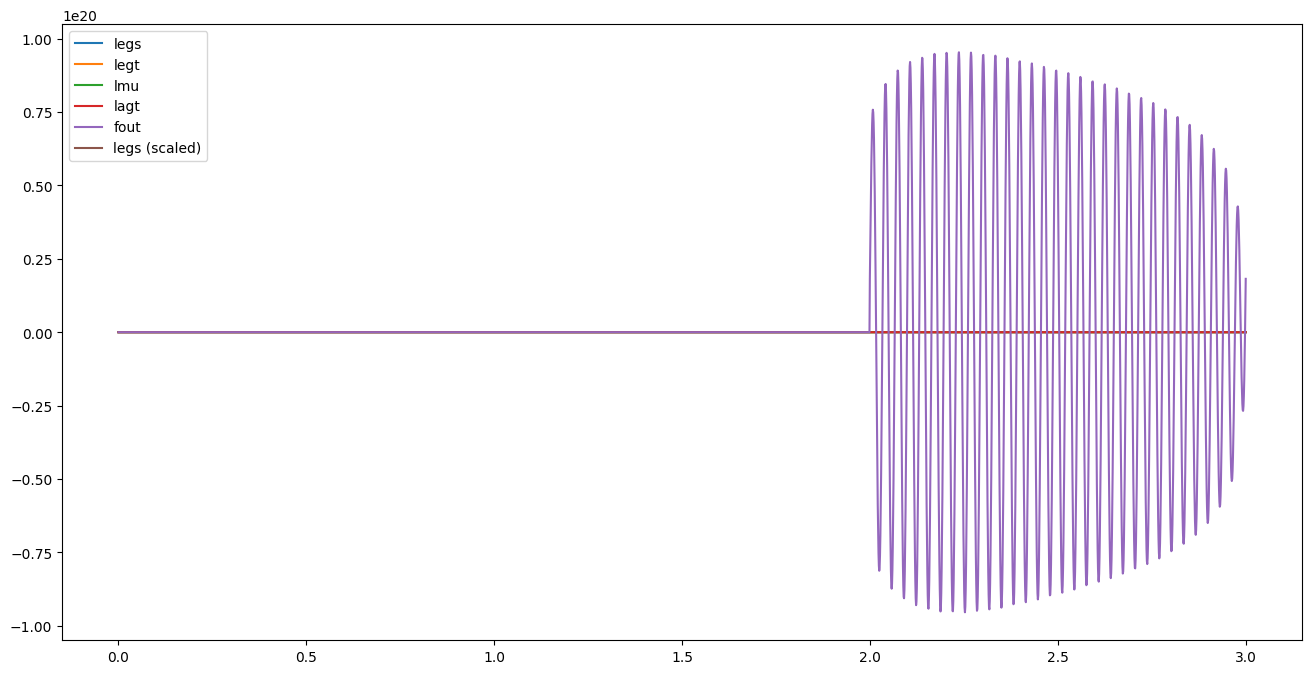

In [14]:
u, y_dict = plot(T=T, dt=dt, N=N, signal=signal, vals=vals, alpha=0.0)

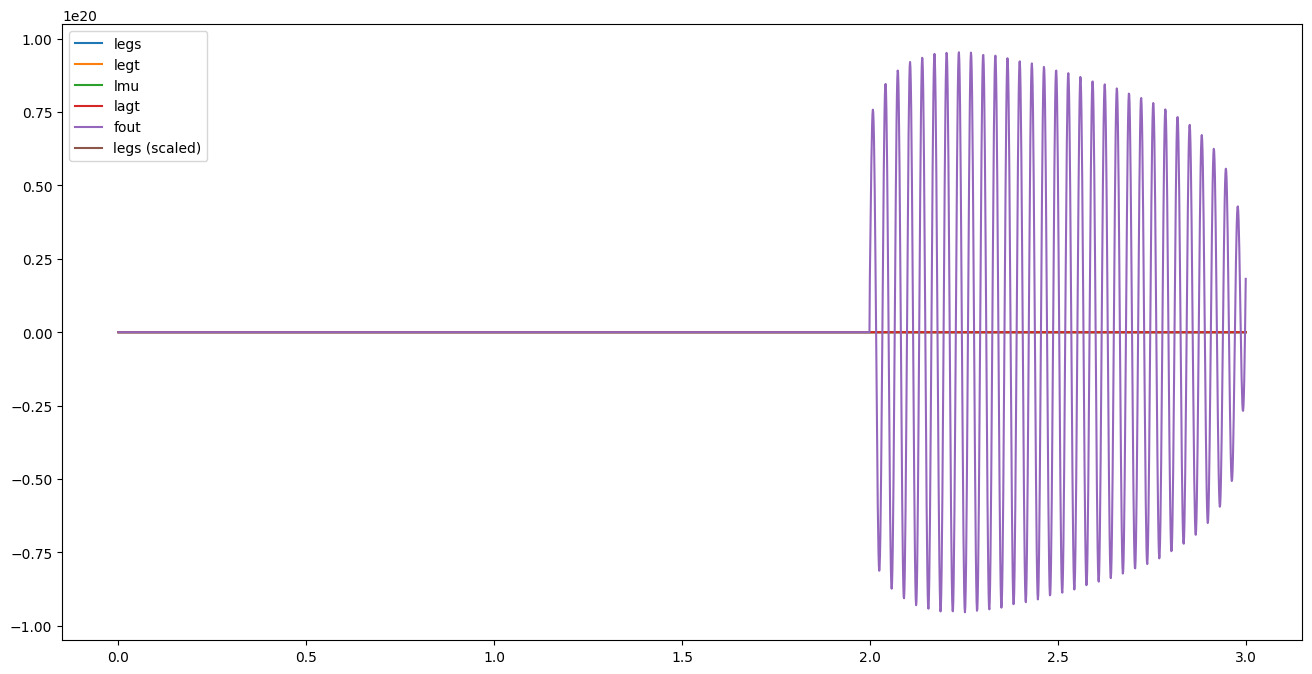

In [15]:
gu_u, gu_y_dict = gu_plot(T=T, dt=dt, N=N, signal=signal, vals=vals, alpha=0.0)

#### LegS

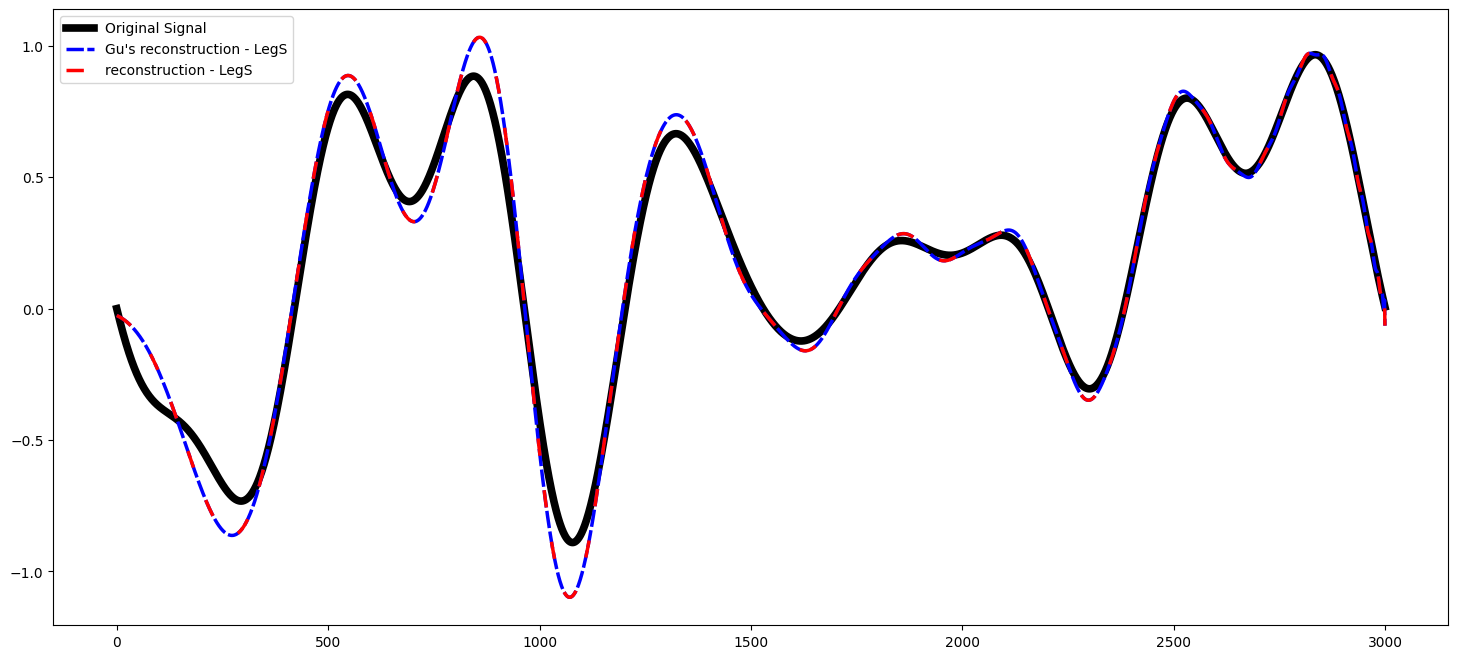

In [16]:
gu_y = gu_y_dict["legslti"]
y = y_dict["legslti"]
plot_comparison(u=u, gu_y=gu_y, y=y, method="LegS")

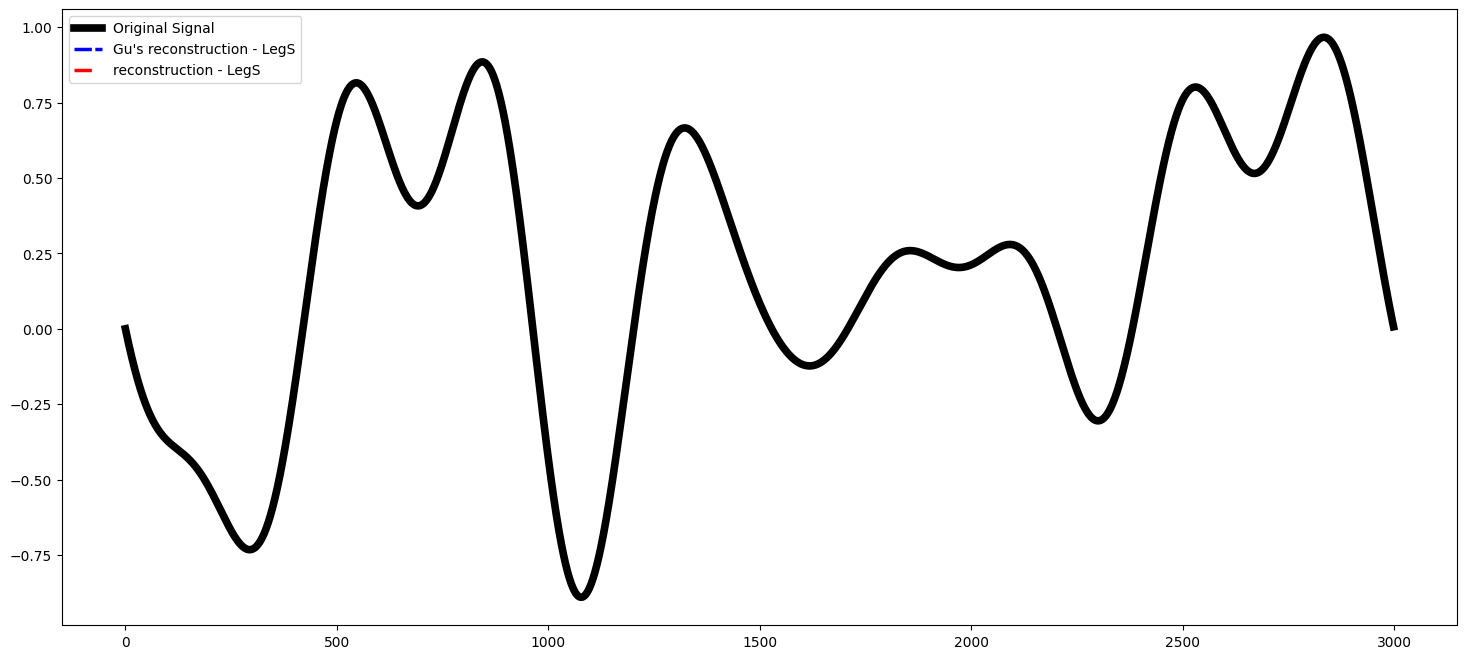

In [17]:
gu_y = gu_y_dict["legslsi"]
y = y_dict["legslsi"]
plot_comparison(u=u, gu_y=gu_y, y=y, method="LegS")

#### LegT

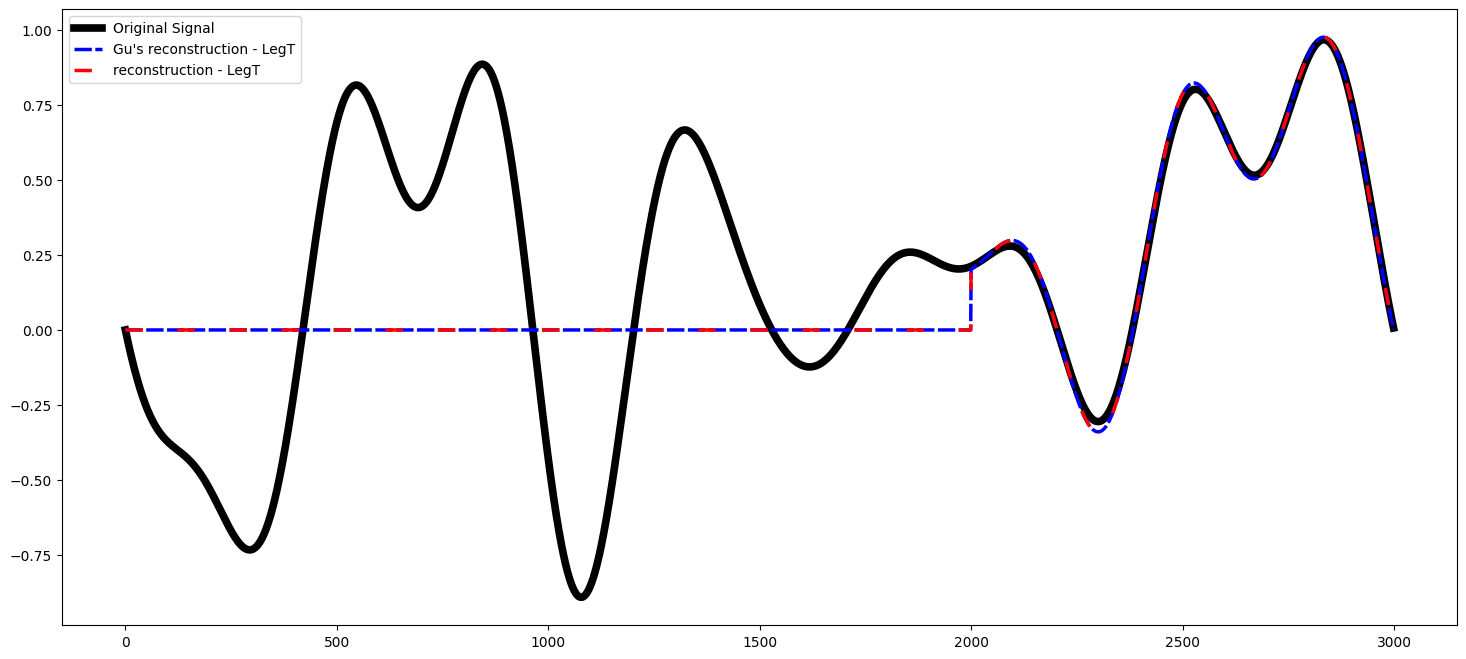

In [18]:
gu_y = gu_y_dict["legtlti"]
y = y_dict["legtlti"]
plot_comparison(u=u, gu_y=gu_y, y=y, method="LegT")

#### LMU

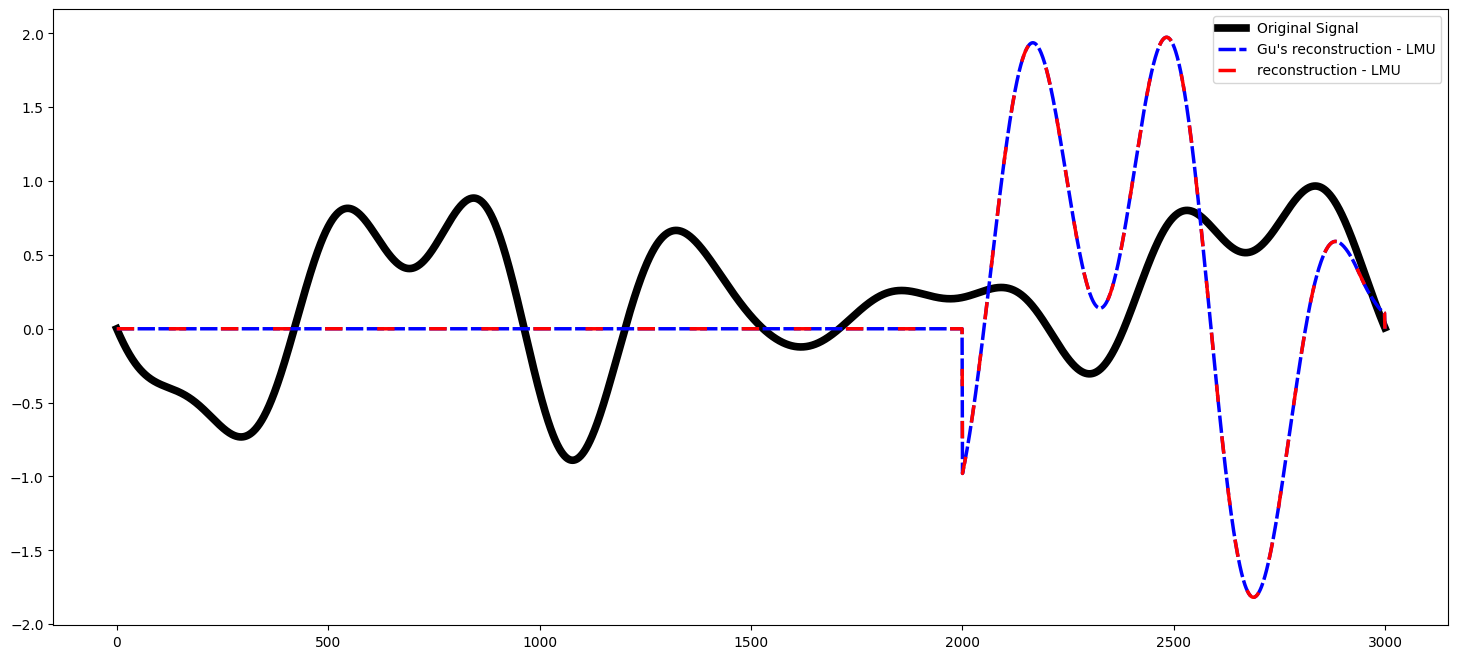

In [19]:
gu_y = gu_y_dict["lmulti"]
y = y_dict["lmulti"]
plot_comparison(u=u, gu_y=gu_y, y=y, method="LMU")

#### LagT

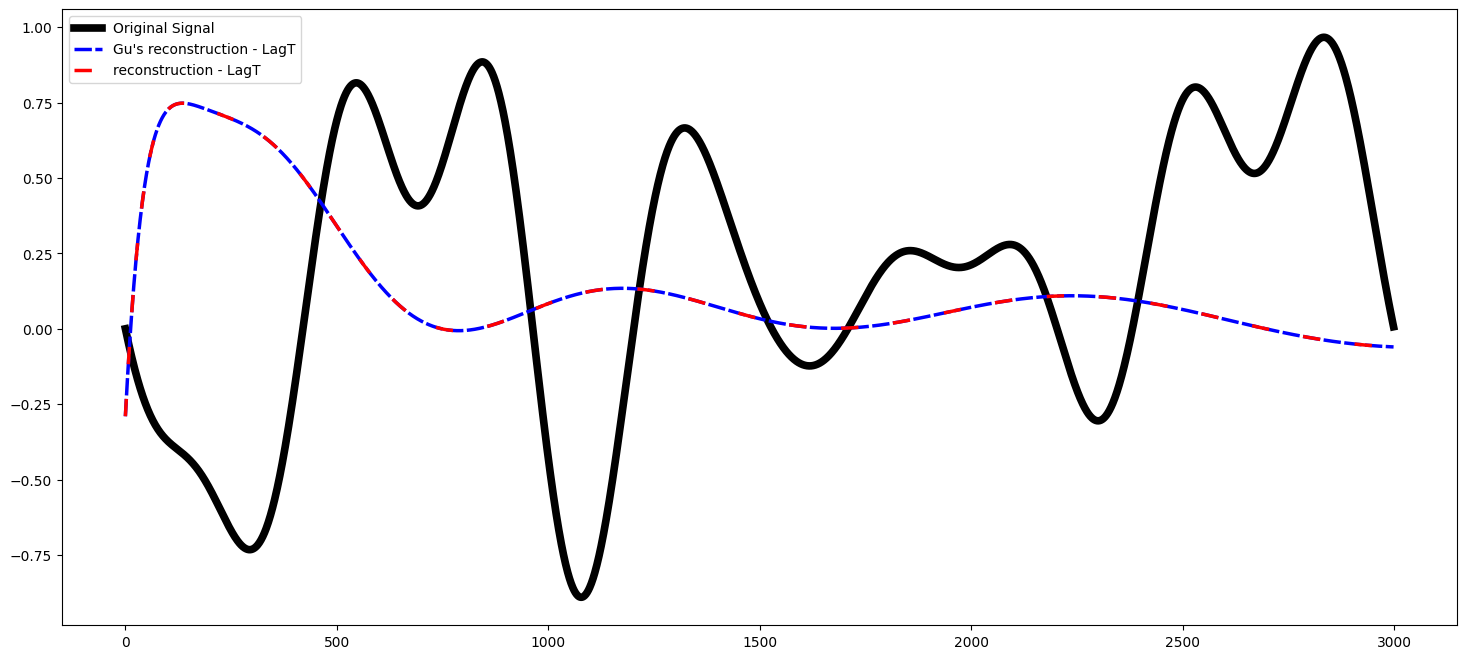

In [20]:
gu_y = gu_y_dict["lagtlti"]
y = y_dict["lagtlti"]
plot_comparison(u=u, gu_y=gu_y, y=y, method="LagT")

#### FouT

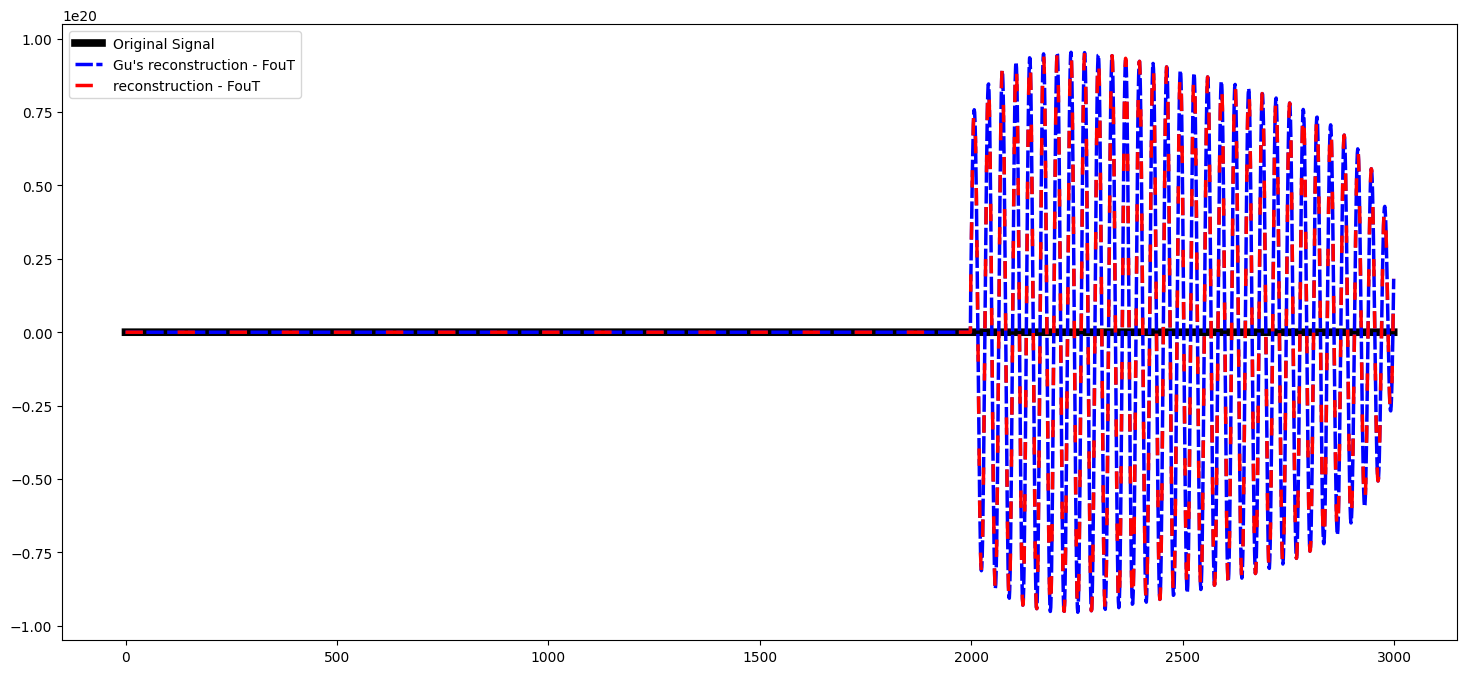

In [21]:
gu_y = gu_y_dict["foutlti"]
y = y_dict["foutlti"]
plot_comparison(u=u, gu_y=gu_y, y=y, method="FouT")

### Testing (LTI and LSI) Reconstructions With Backward Euler Transform

/home/beegass/.cache/pypoetry/virtualenvs/s4mer-pkg-jZnBSgjq-py3.8/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:5117: RuntimeWarning: overflow encountered in cast
  return binary_op(*args)


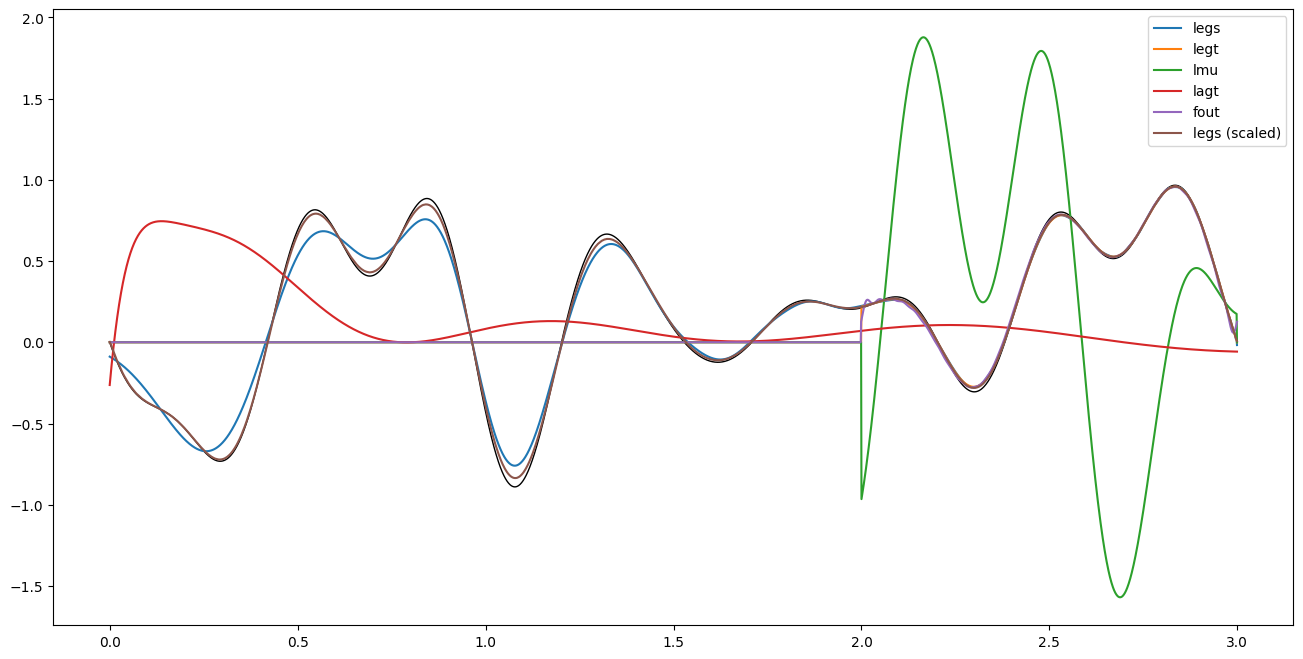

In [22]:
u, y_dict = plot(T=T, dt=dt, N=N, signal=signal, vals=vals, alpha=1.0)

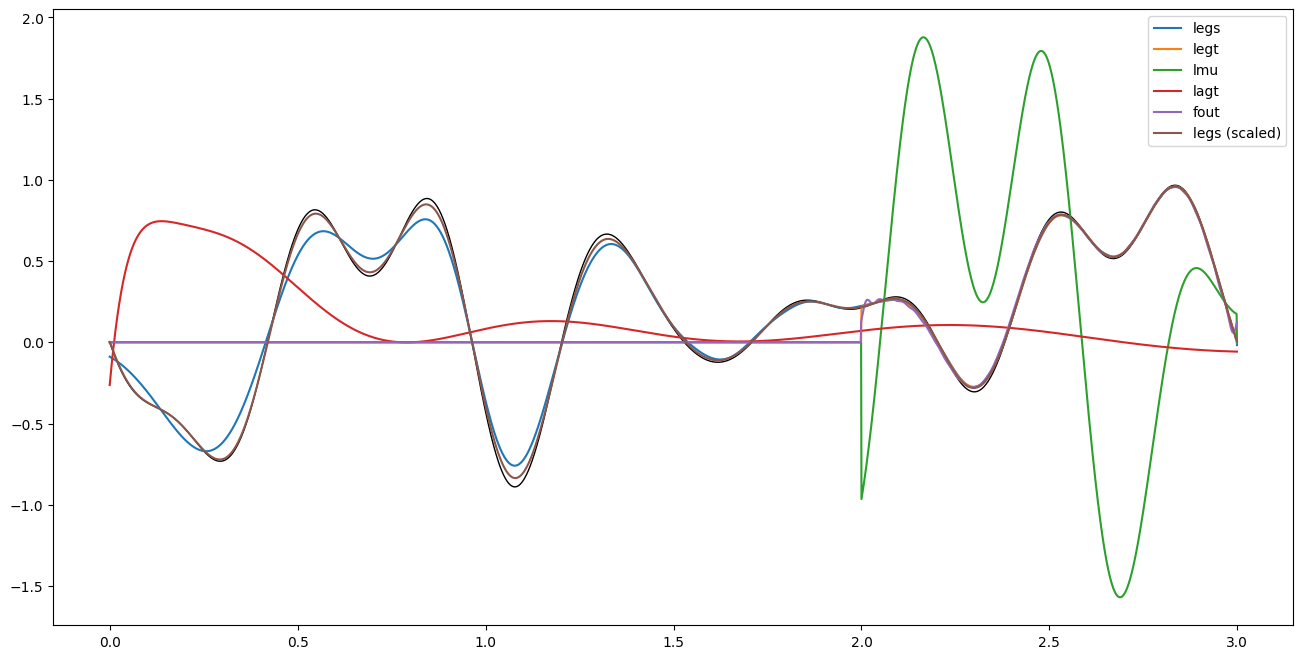

In [23]:
gu_u, gu_y_dict = gu_plot(T=T, dt=dt, N=N, signal=signal, vals=vals, alpha=1.0)

#### LegS

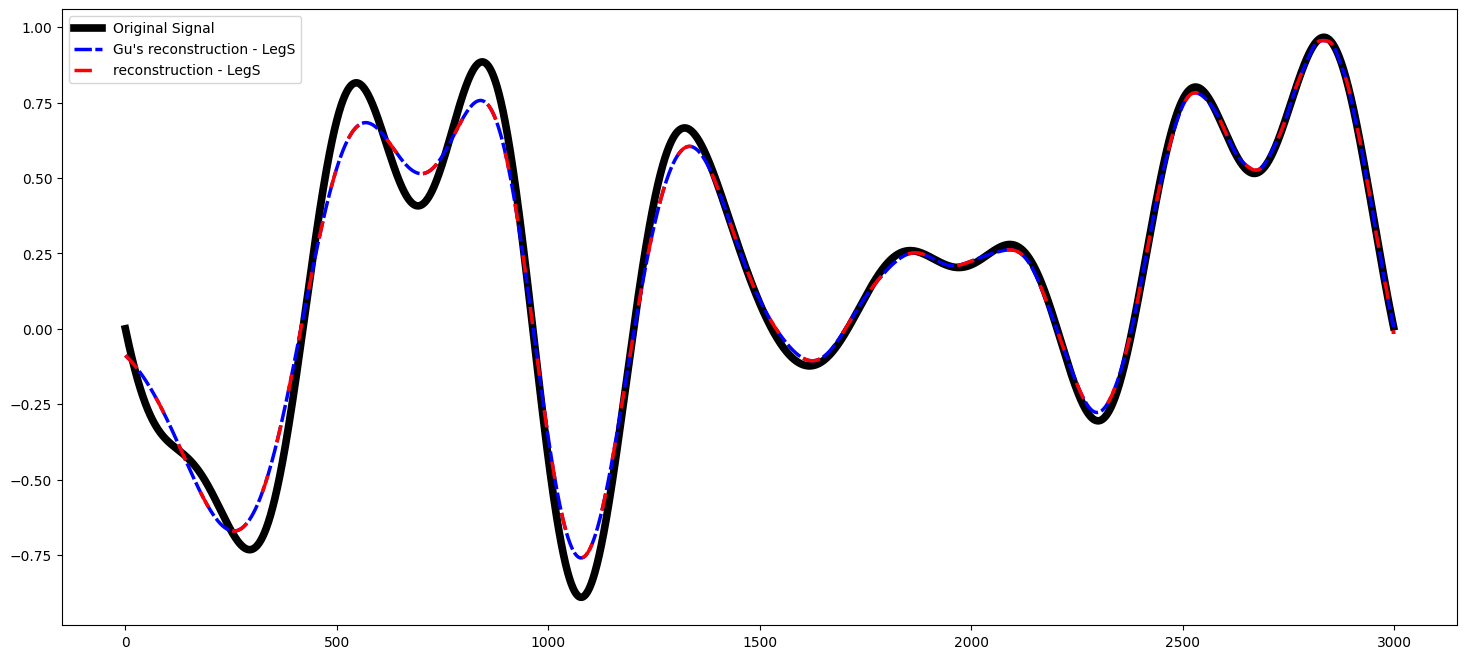

In [24]:
gu_y = gu_y_dict["legslti"]
y = y_dict["legslti"]
plot_comparison(u=u, gu_y=gu_y, y=y, method="LegS")

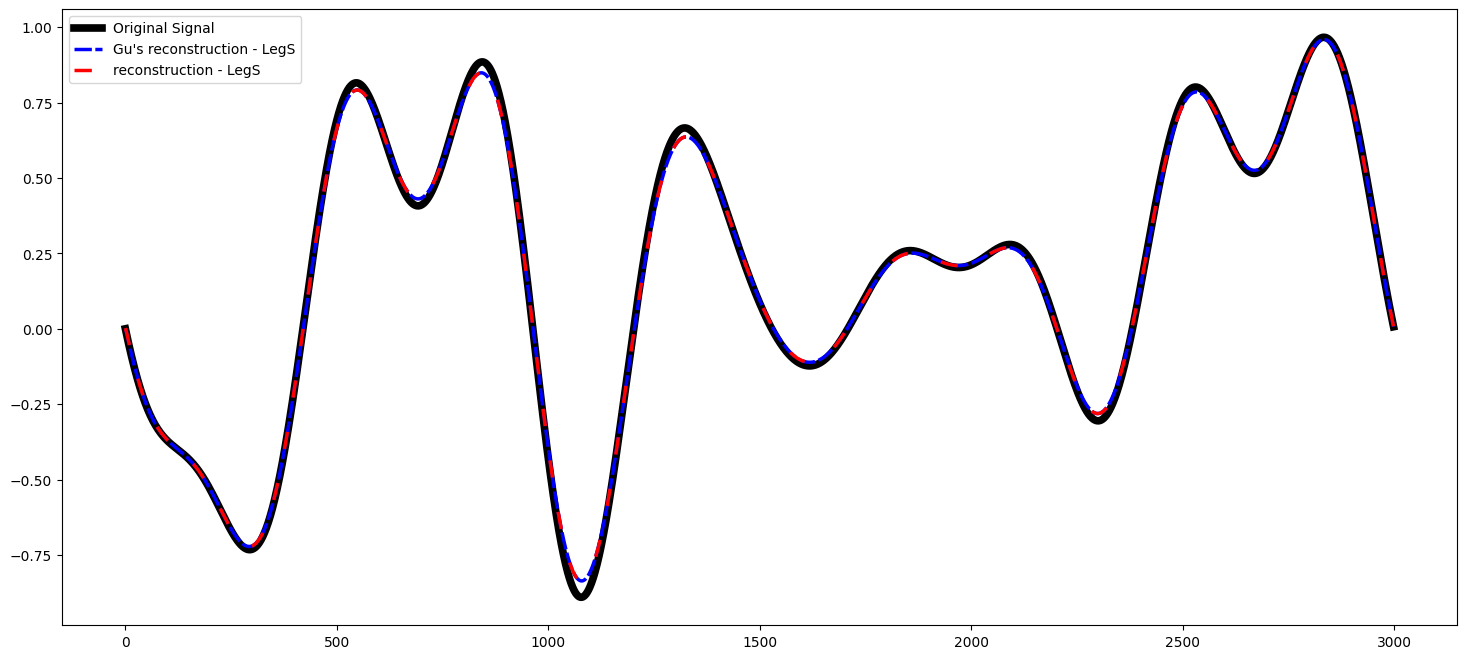

In [25]:
gu_y = gu_y_dict["legslsi"]
y = y_dict["legslsi"]
plot_comparison(u=u, gu_y=gu_y, y=y, method="LegS")

#### LegT

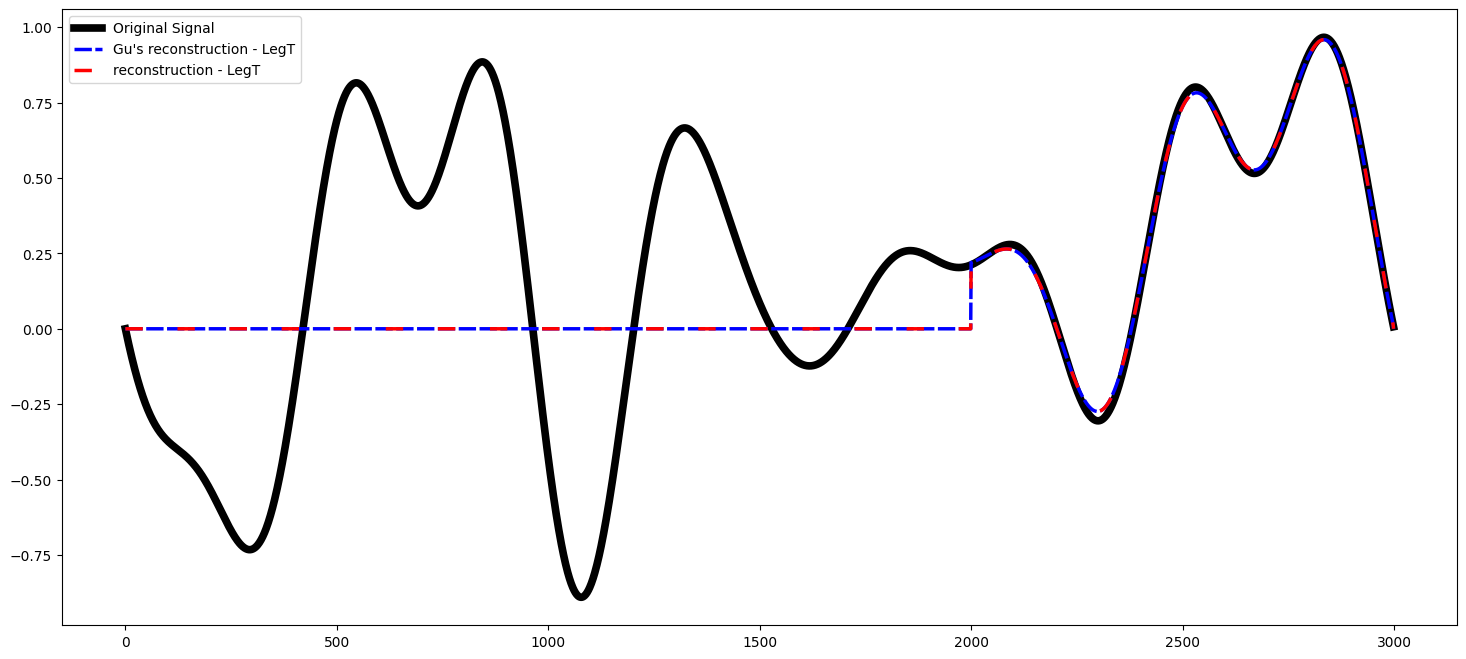

In [26]:
gu_y = gu_y_dict["legtlti"]
y = y_dict["legtlti"]
plot_comparison(u=u, gu_y=gu_y, y=y, method="LegT")

#### LMU

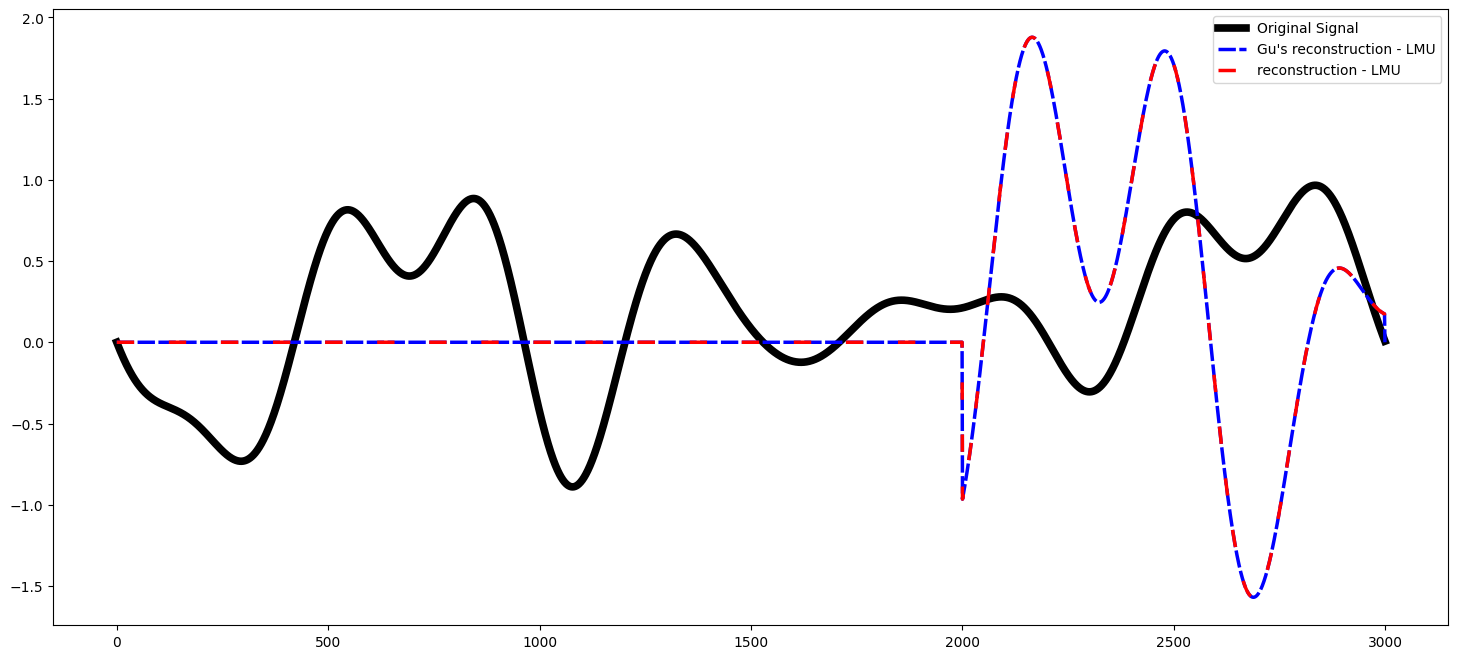

In [27]:
gu_y = gu_y_dict["lmulti"]
y = y_dict["lmulti"]
plot_comparison(u=u, gu_y=gu_y, y=y, method="LMU")

#### LagT

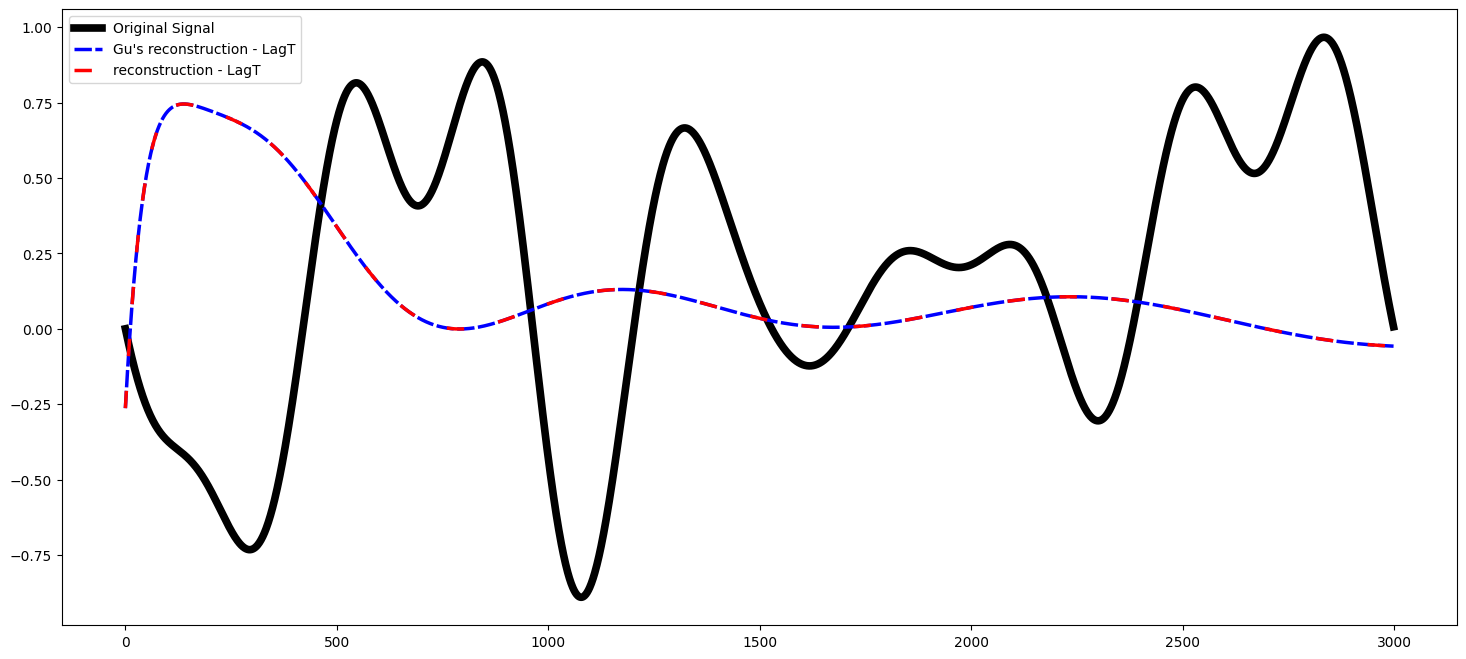

In [28]:
gu_y = gu_y_dict["lagtlti"]
y = y_dict["lagtlti"]
plot_comparison(u=u, gu_y=gu_y, y=y, method="LagT")

#### FouT

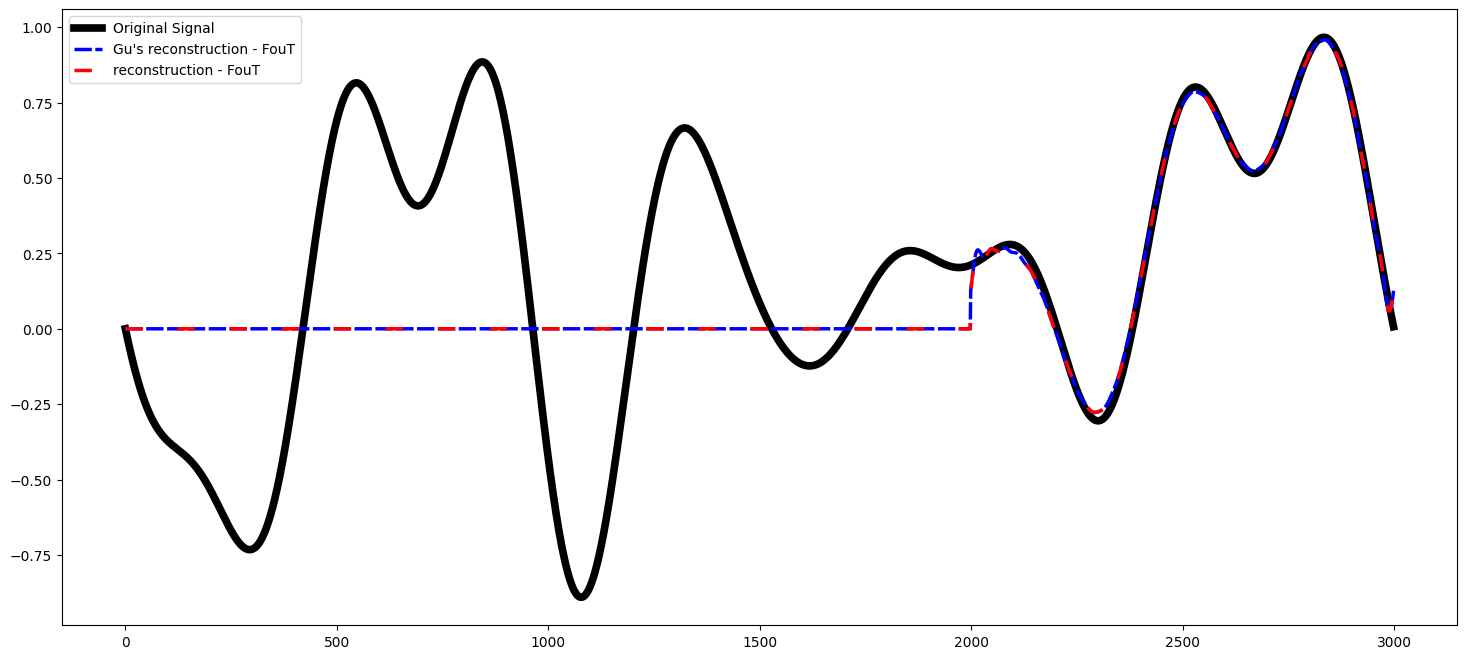

In [29]:
gu_y = gu_y_dict["foutlti"]
y = y_dict["foutlti"]
plot_comparison(u=u, gu_y=gu_y, y=y, method="FouT")

### Testing (LTI and LSI) Reconstructions With Bilinear Transform

/home/beegass/.cache/pypoetry/virtualenvs/s4mer-pkg-jZnBSgjq-py3.8/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:5117: RuntimeWarning: overflow encountered in cast
  return binary_op(*args)


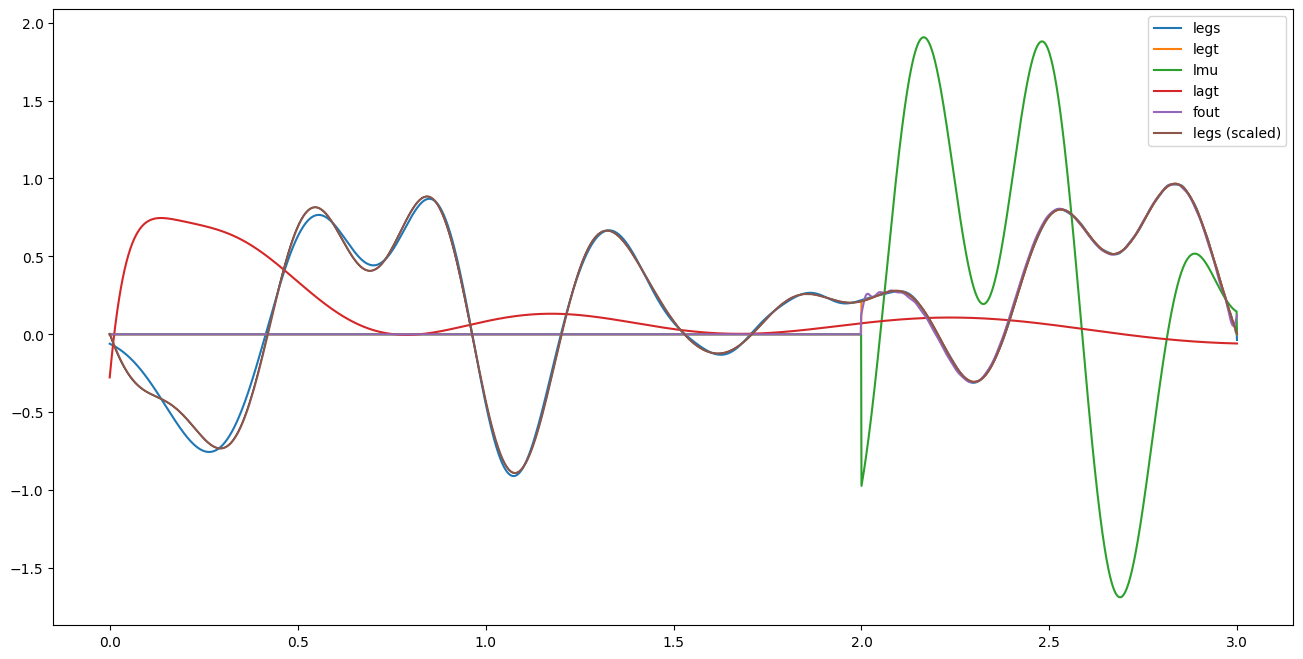

In [30]:
u, y_dict = plot(T=T, dt=dt, N=N, signal=signal, vals=vals, alpha=0.5)

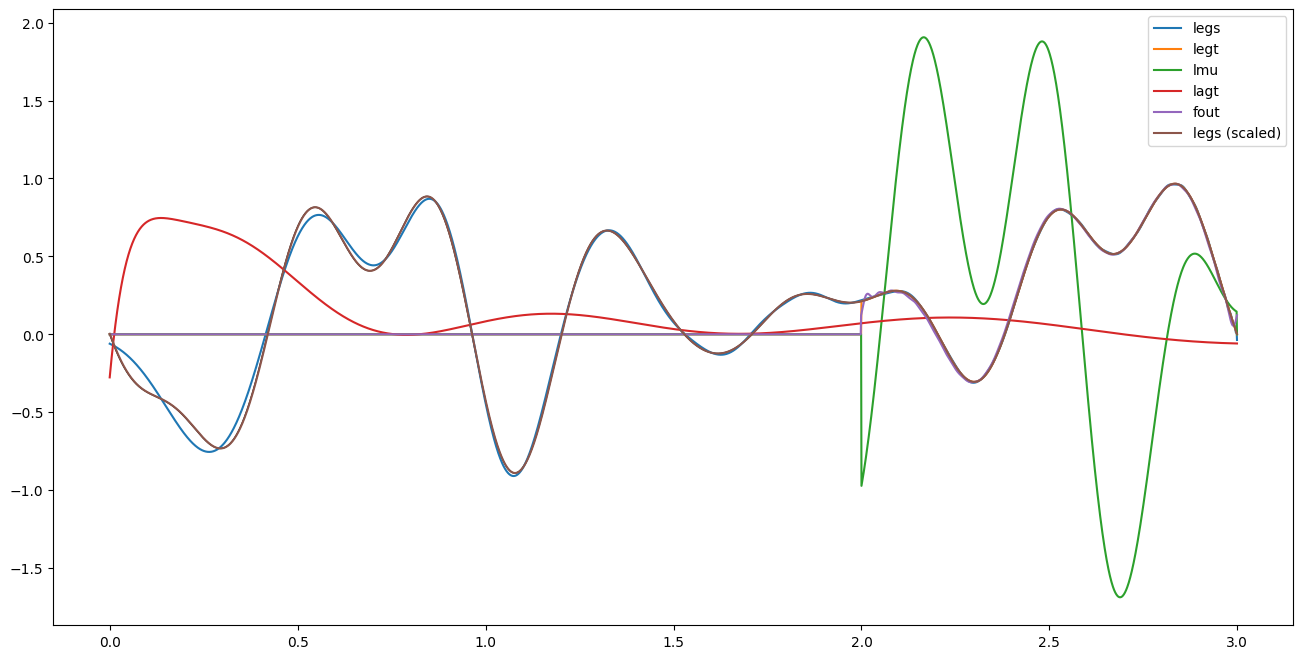

In [31]:
gu_u, gu_y_dict = gu_plot(T=T, dt=dt, N=N, signal=signal, vals=vals, alpha=0.5)

#### LegS

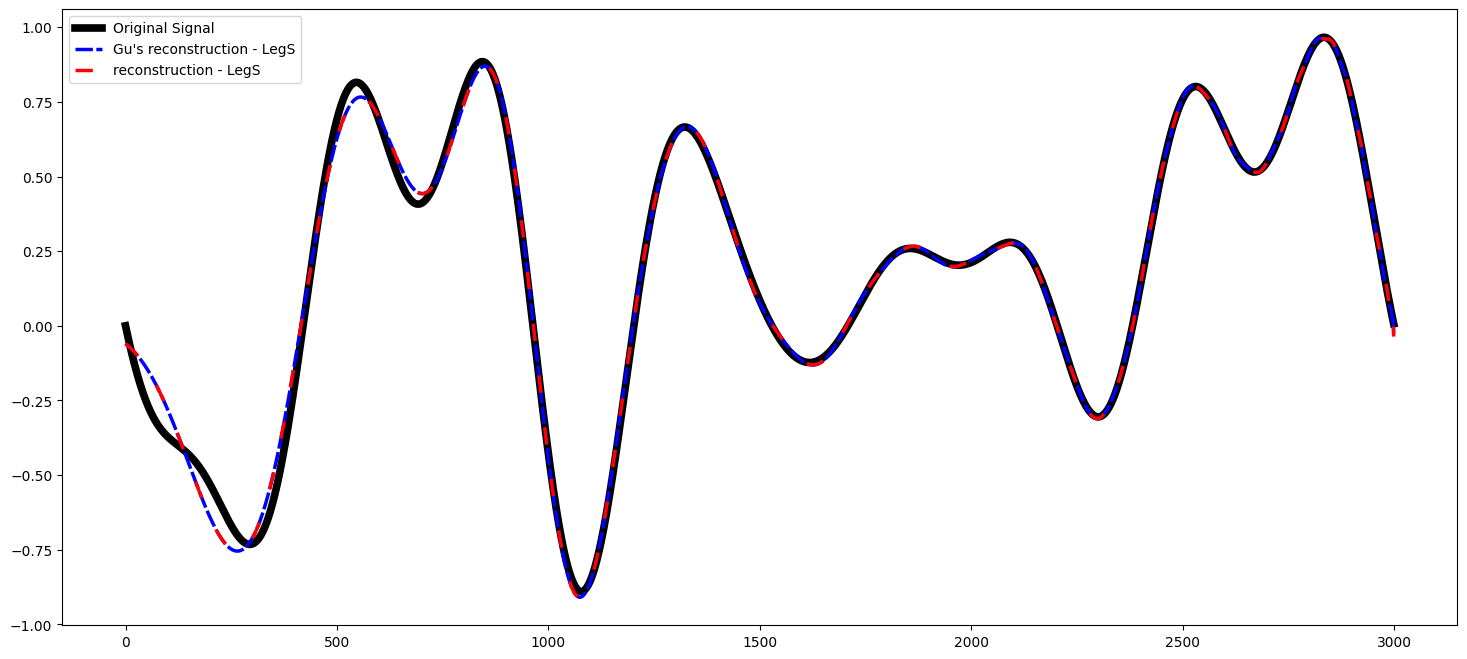

In [32]:
gu_y = gu_y_dict["legslti"]
y = y_dict["legslti"]
plot_comparison(u=u, gu_y=gu_y, y=y, method="LegS")

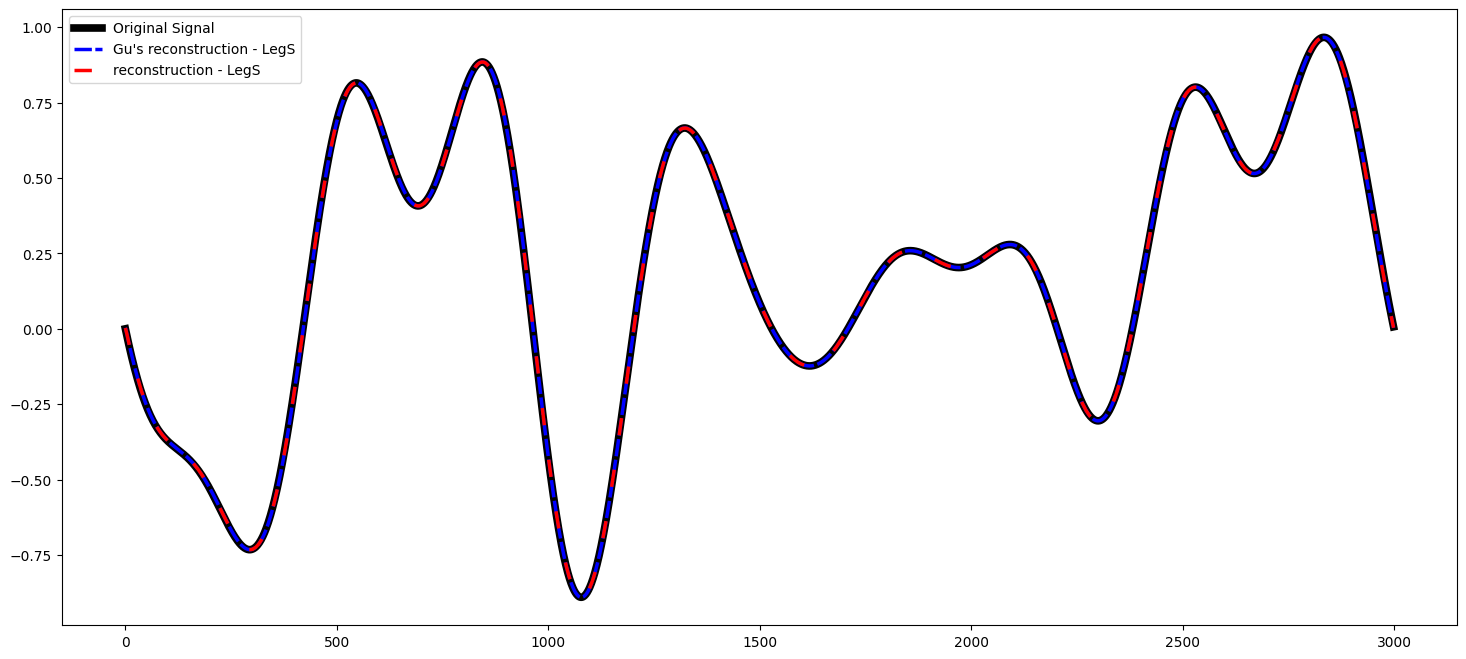

In [33]:
gu_y = gu_y_dict["legslsi"]
y = y_dict["legslsi"]
plot_comparison(u=u, gu_y=gu_y, y=y, method="LegS")

#### LegT

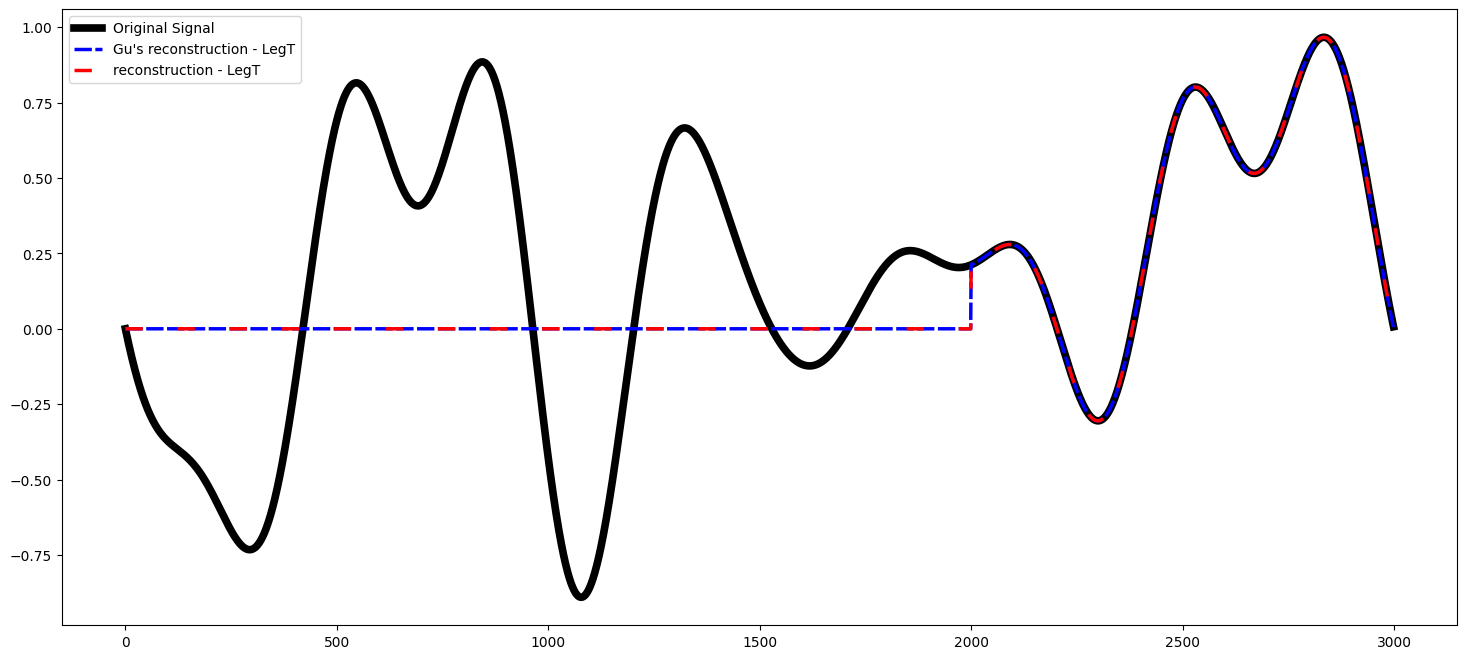

In [34]:
gu_y = gu_y_dict["legtlti"]
y = y_dict["legtlti"]
plot_comparison(u=u, gu_y=gu_y, y=y, method="LegT")

#### LMU

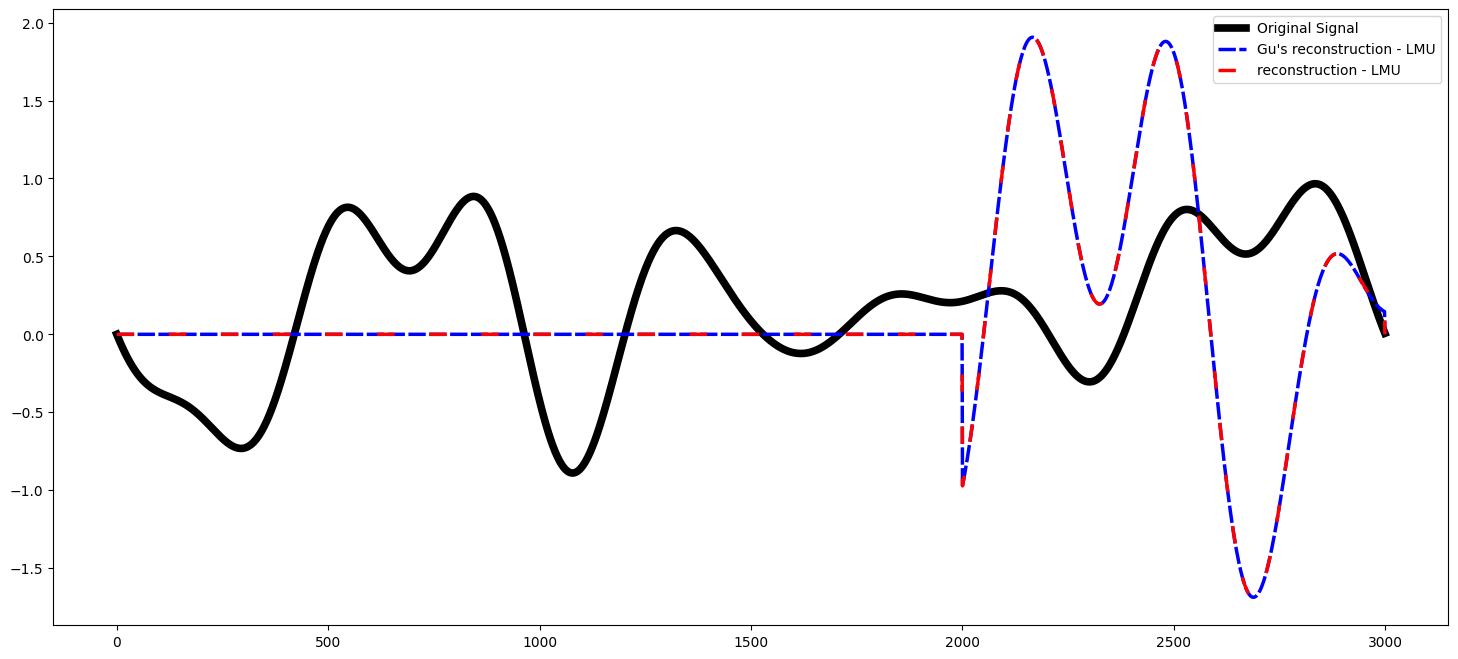

In [35]:
gu_y = gu_y_dict["lmulti"]
y = y_dict["lmulti"]
plot_comparison(u=u, gu_y=gu_y, y=y, method="LMU")

#### LagT

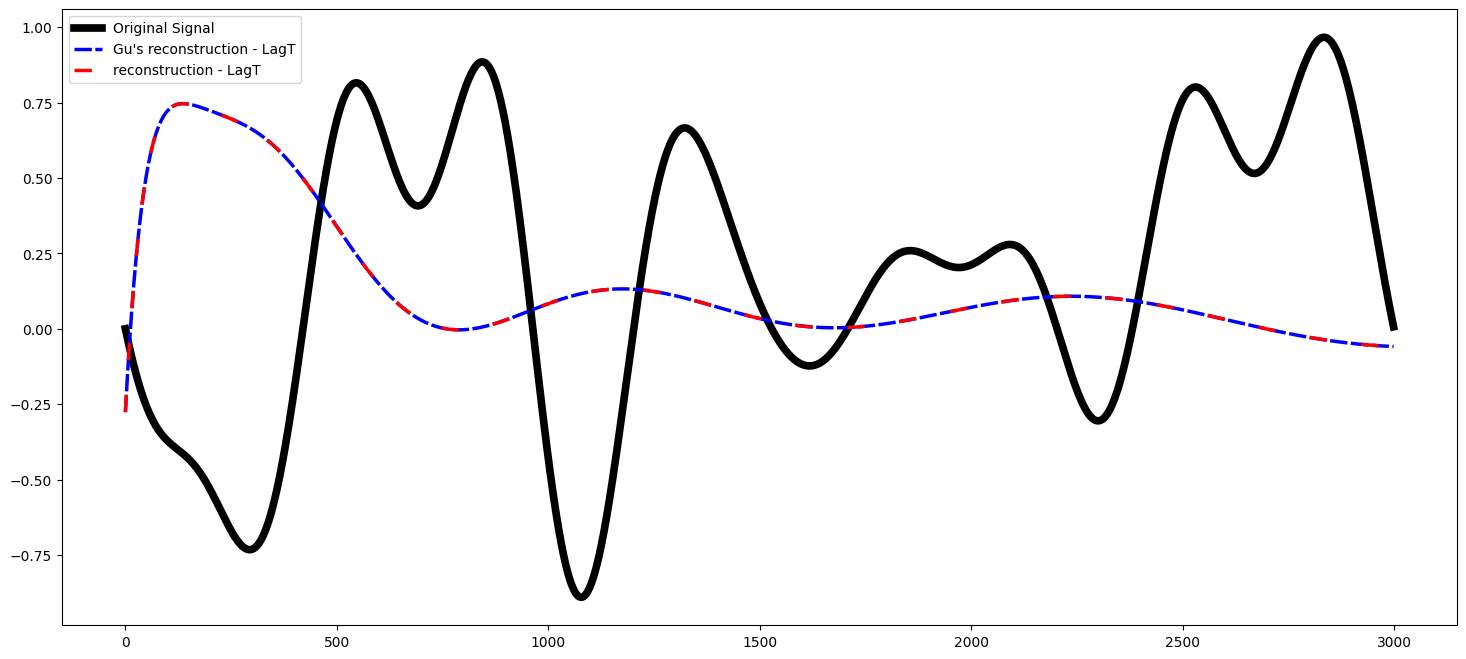

In [36]:
gu_y = gu_y_dict["lagtlti"]
y = y_dict["lagtlti"]
plot_comparison(u=u, gu_y=gu_y, y=y, method="LagT")

#### FouT

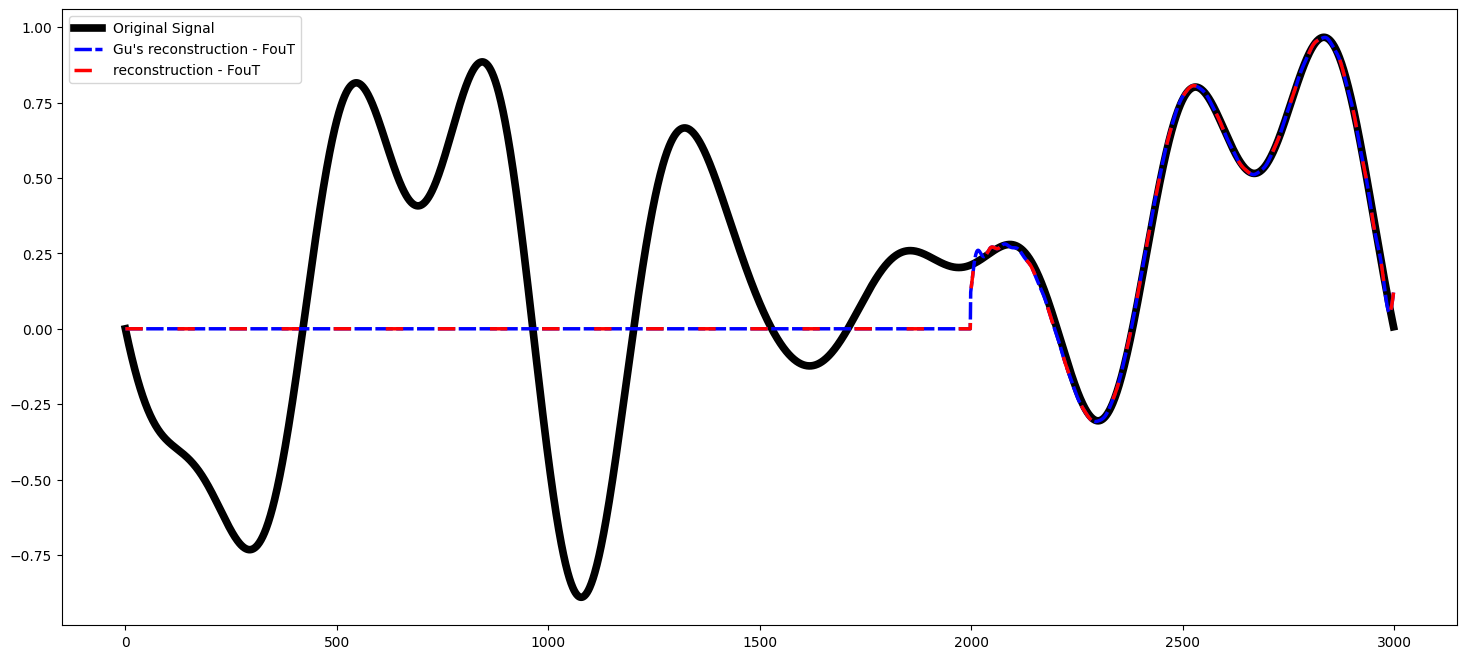

In [37]:
gu_y = gu_y_dict["foutlti"]
y = y_dict["foutlti"]
plot_comparison(u=u, gu_y=gu_y, y=y, method="FouT")

### Testing (LTI and LSI) Reconstructions With Zero-Order Hold (ZOH) Transform

/home/beegass/.cache/pypoetry/virtualenvs/s4mer-pkg-jZnBSgjq-py3.8/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:5117: RuntimeWarning: overflow encountered in cast
  return binary_op(*args)


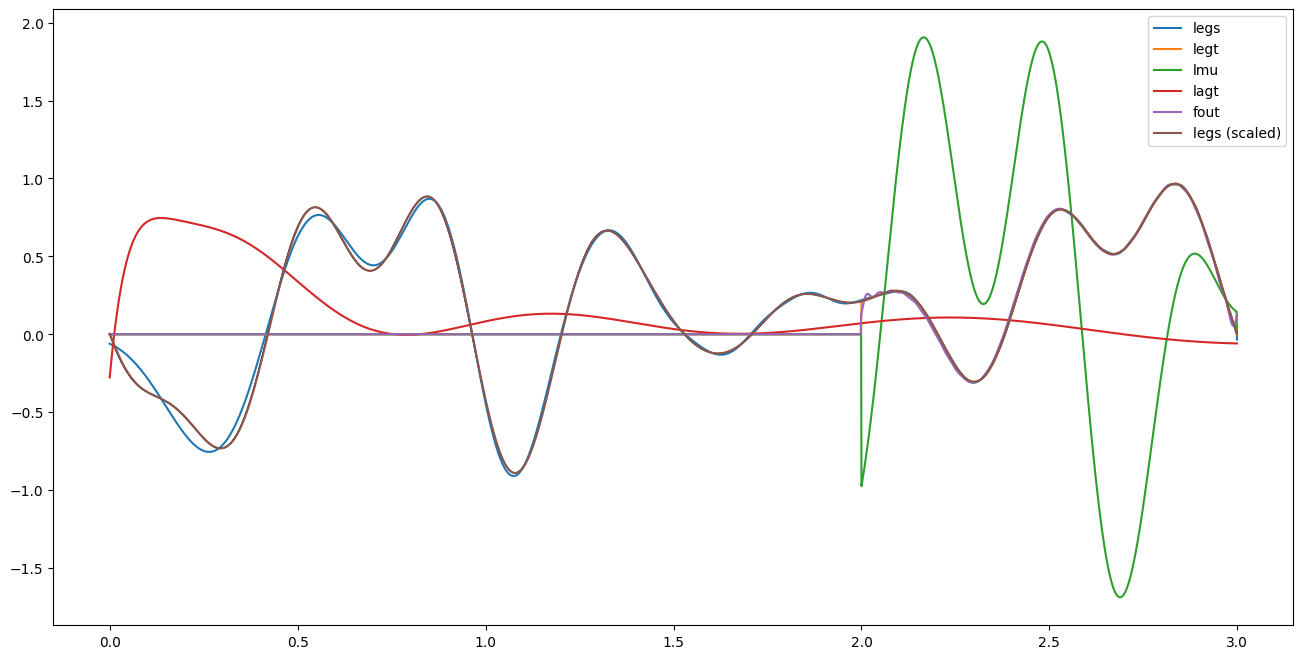

In [38]:
u, y_dict = plot(T=T, dt=dt, N=N, signal=signal, vals=vals, alpha=2.0)

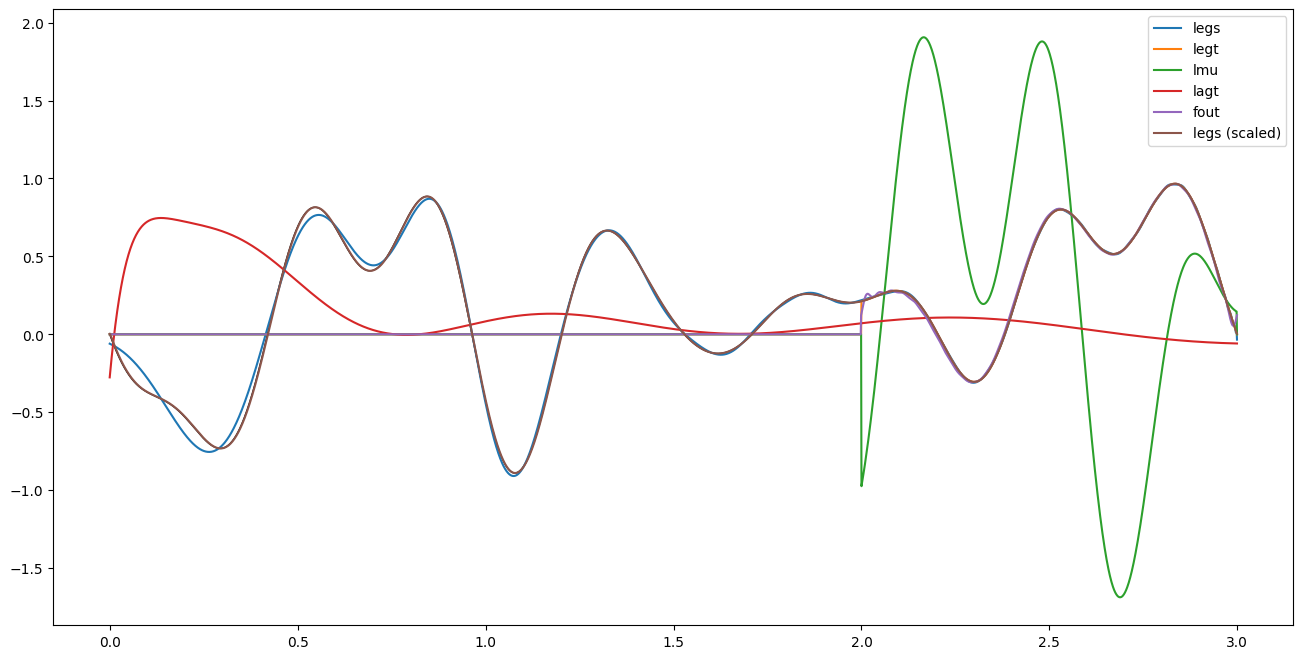

In [39]:
gu_u, gu_y_dict = gu_plot(T=T, dt=dt, N=N, signal=signal, vals=vals, alpha="zoh")

#### LegS

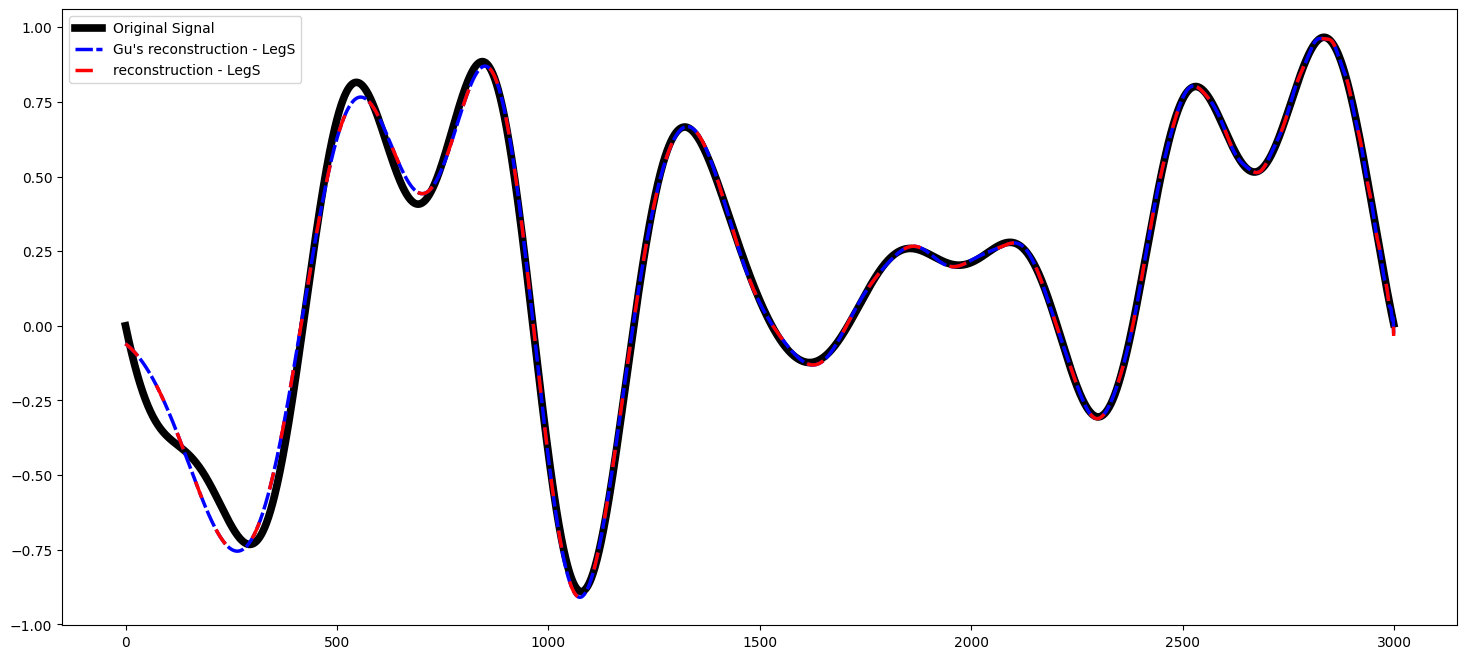

In [40]:
gu_y = gu_y_dict["legslti"]
y = y_dict["legslti"]
plot_comparison(u=u, gu_y=gu_y, y=y, method="LegS")

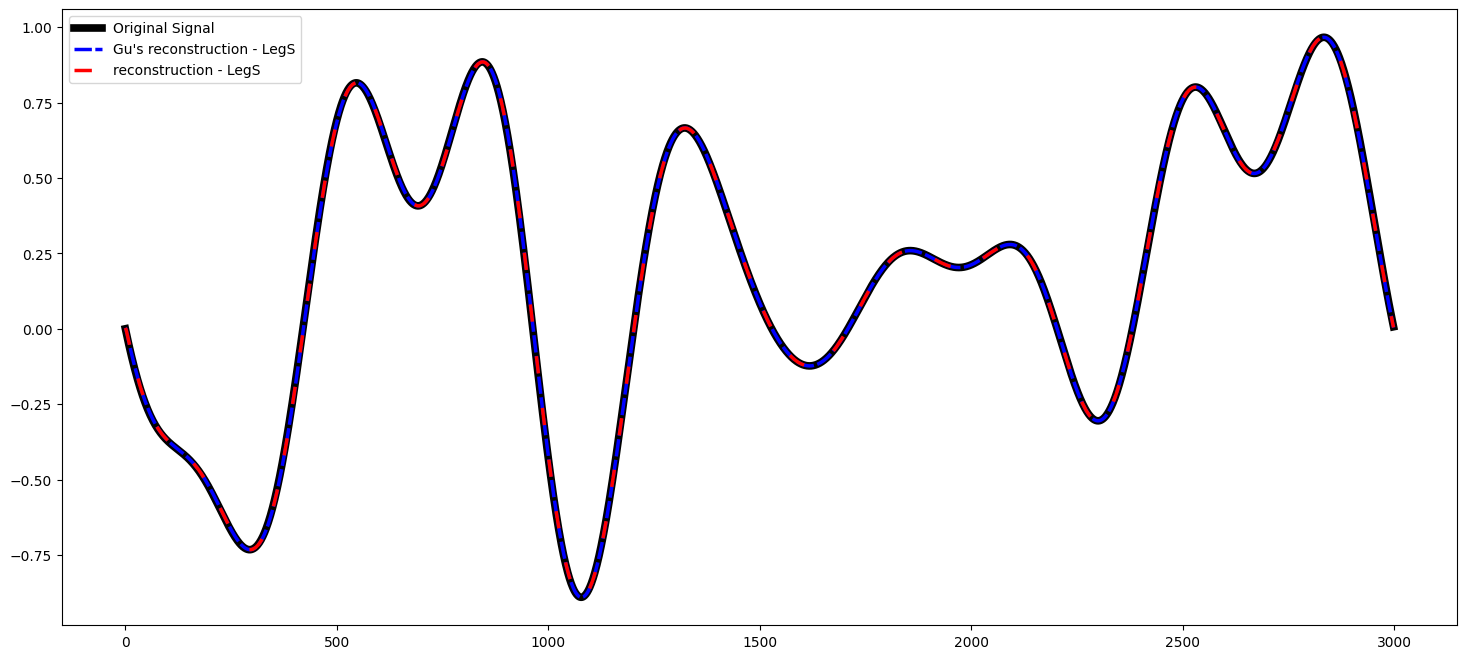

In [41]:
gu_y = gu_y_dict["legslsi"]
y = y_dict["legslsi"]
plot_comparison(u=u, gu_y=gu_y, y=y, method="LegS")

#### LegT

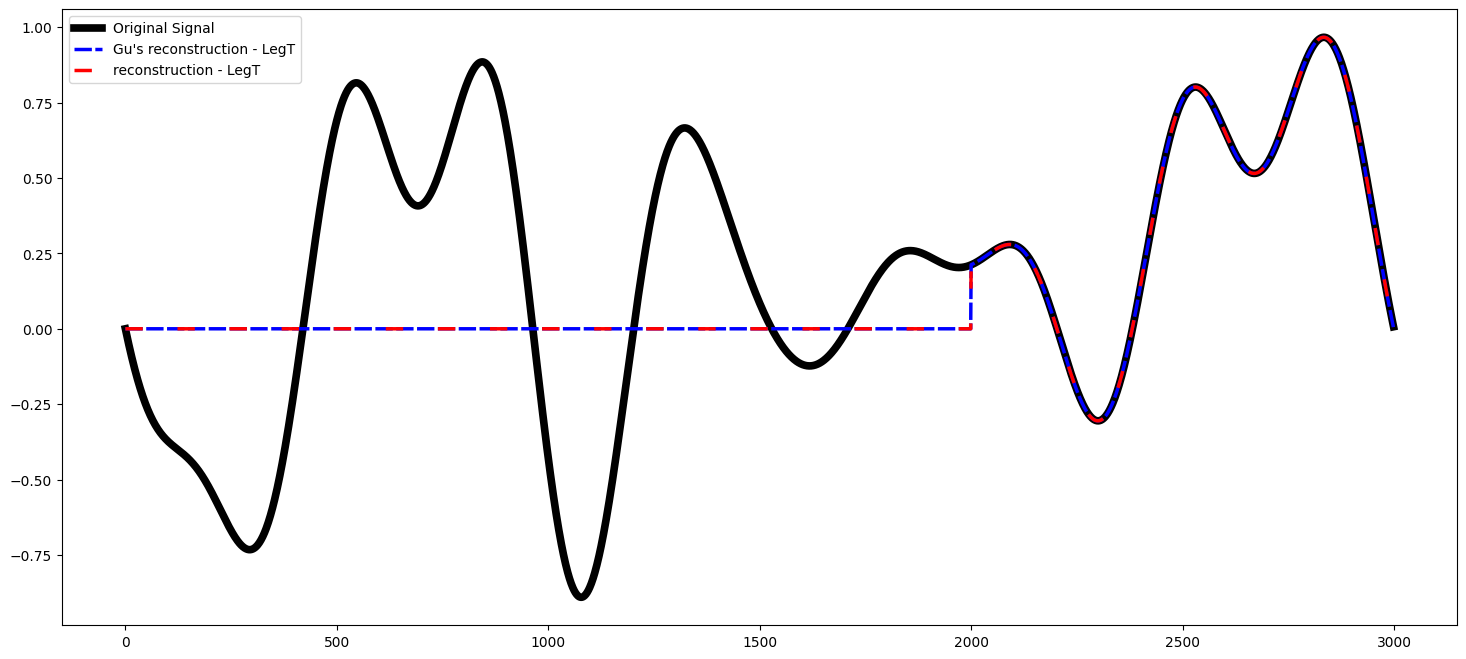

In [42]:
gu_y = gu_y_dict["legtlti"]
y = y_dict["legtlti"]
plot_comparison(u=u, gu_y=gu_y, y=y, method="LegT")

#### LMU

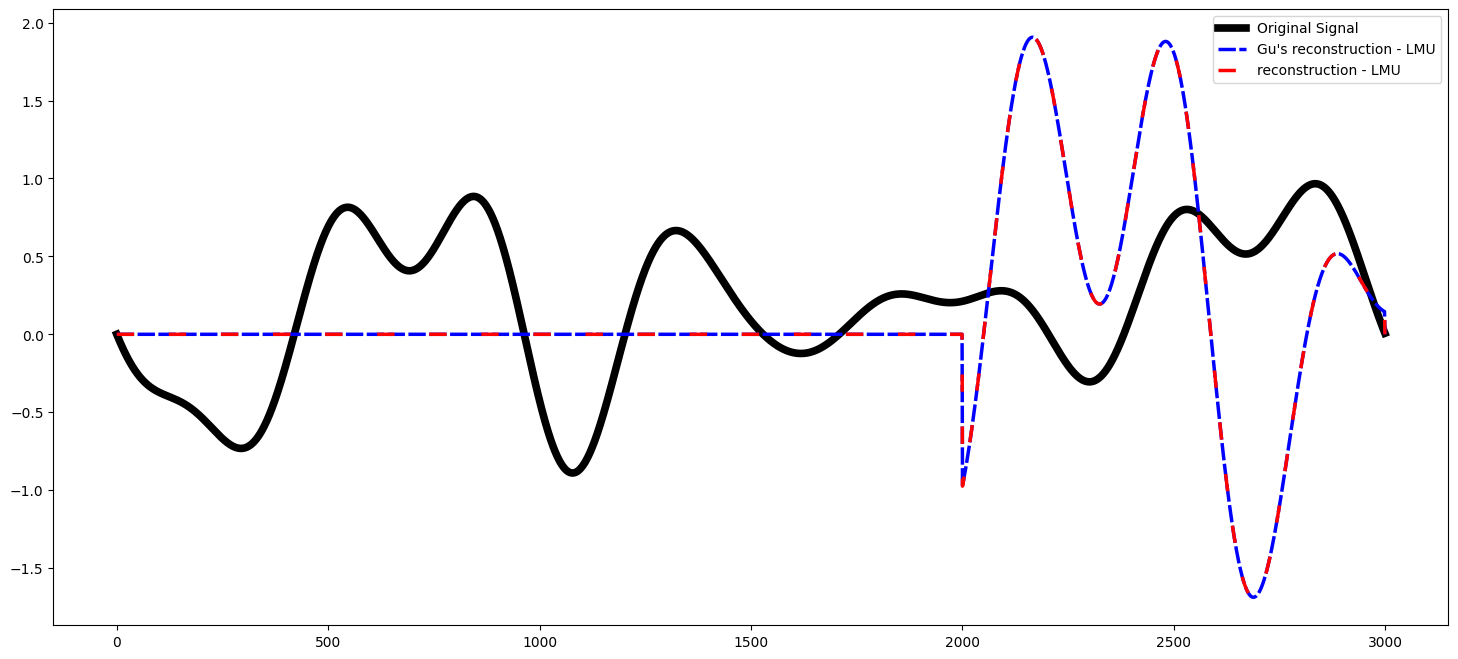

In [43]:
gu_y = gu_y_dict["lmulti"]
y = y_dict["lmulti"]
plot_comparison(u=u, gu_y=gu_y, y=y, method="LMU")

#### LagT

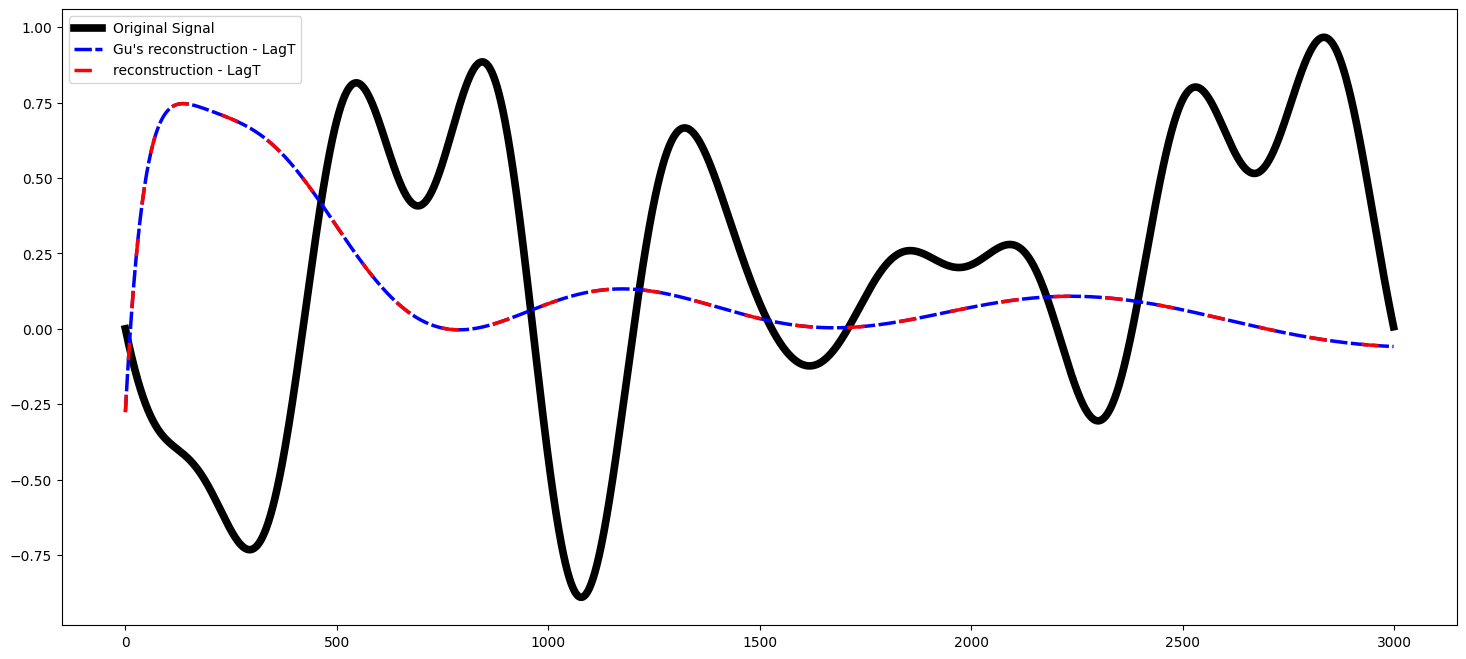

In [44]:
gu_y = gu_y_dict["lagtlti"]
y = y_dict["lagtlti"]
plot_comparison(u=u, gu_y=gu_y, y=y, method="LagT")

#### FouT

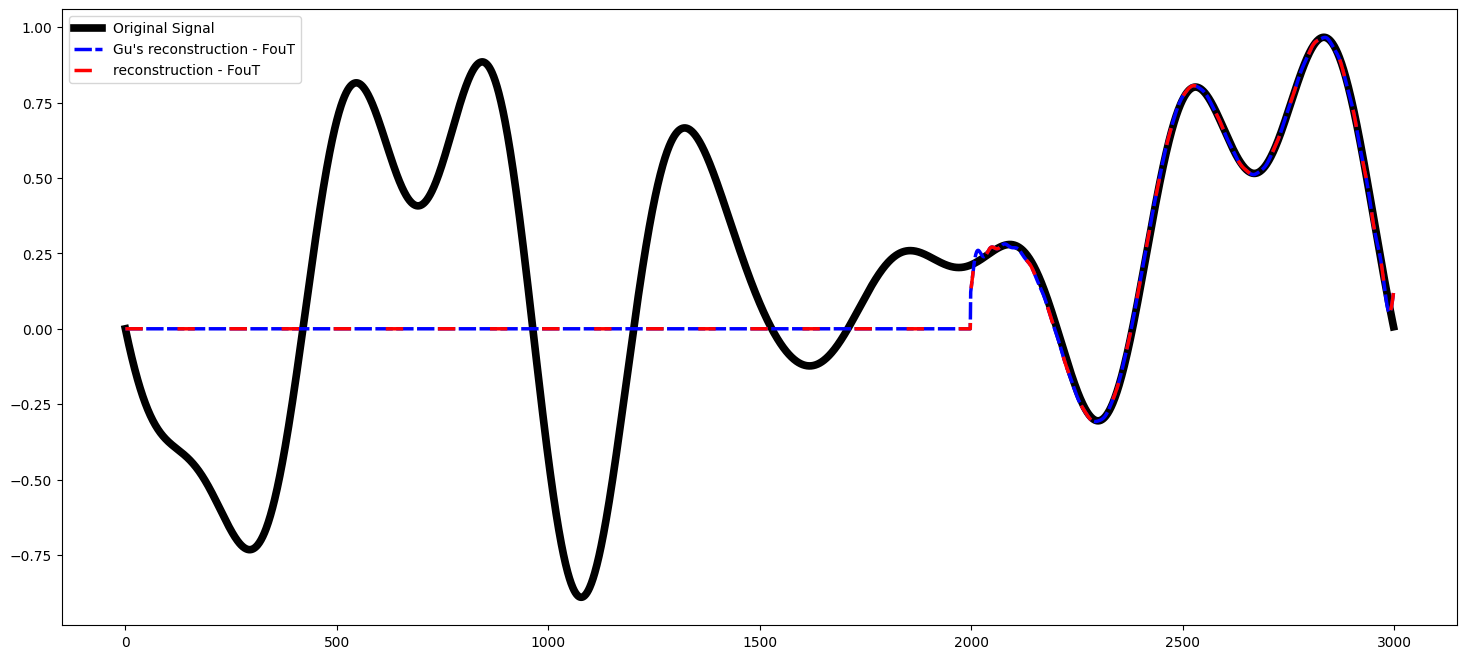

In [45]:
gu_y = gu_y_dict["foutlti"]
y = y_dict["foutlti"]
plot_comparison(u=u, gu_y=gu_y, y=y, method="FouT")